Para el siguiente concurso de datos empezaremos realizando un primer flujo completo (con preprocesado rápido, aplicación del modelo y adaptación del formato que queremos) para subirlo a la plataforma y ver el resultado. Posteriormente, iremos probando diferentes modificaciones con el objetivo de conseguir un modelo con el mejor score posible.

El primer paso será importar las librerías necesarias para el trabajo y visualizar los datos que nos presenta el enunciado.

## Importación de librerías

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from scipy import stats
import sklearn.impute as skl_imp
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.decomposition import PCA
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

## Carga de datos

In [115]:
df_train = pd.read_csv("x_train.csv", index_col=0)
df_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [116]:
y_train = pd.read_csv("y_train.csv", index_col=0)
y_train

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional
...,...
60739,functional
27263,functional
37057,functional


In [117]:
df_test = pd.read_csv("x_test.csv", index_col=0)
df_test

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,Wami / Ruvu,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,Pangani,...,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,Internal,...,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe


# Primer Modelo

Vamos a empezar haciendo un flujo completo con una **primera aproximación** y un preprocesado rápido para tener un punto de partida sobre el que después iremos trabajando.

In [5]:
df_train_prueba = pd.read_csv("x_train.csv", index_col=0)
y_train_prueba = pd.read_csv("y_train.csv", index_col=0)
df_test_prueba = pd.read_csv("x_test.csv", index_col=0)

df_train_prueba

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump


In [6]:
# Probamos eliminando columnas innecesarias (según nuestro criterio) para el entrenamiento y validación del modelo
columns_to_drop = [
    'date_recorded','funder', 'installer','wpt_name','num_private','subvillage','region','lga','ward',
    'recorded_by','scheme_name','extraction_type_group','extraction_type_class',
    'management_group','payment_type','quality_group','source_type',
    'source_class','waterpoint_type_group']

df_train_prueba = df_train_prueba.drop(columns=columns_to_drop)
df_test_prueba = df_test_prueba.drop(columns=columns_to_drop)

Hemos eliminado las siguientes columnas:

    - 'date_recorded', 'recorded_by': por ser simplemente la fecha en la que se grabó el dato y quién lo grabó.
    
    - 'funder', 'installer', 'wpt_name', 'scheme_name': solo nos dice el nombre de la financiera, los instaladores, el punto de agua y quién lo opera.
    
    - 'num_private': -
    
    - 'subvillage', 'region','lga','ward': nos quedamos con 'region_code' y 'district_code' que nos dan prácticamente la misma información.
    
    - 'extraction_type_group','extraction_type_class': nos quedamos solo con 'extraction_type'.
    
    - 'management_group','payment_type','quality_group','quantity_group','source_type','source_class','waterpoint_type_group': al igual que en el caso anterior, nos quedamos solo con el elemento más "general" de esas variables.

In [7]:
# Imputamos los valores nulos de forma rápida: la media para valores numéricos y moda para los categóricos
cat_var = df_train_prueba.select_dtypes(include=['object']).columns
num_var = df_train_prueba.select_dtypes(include=[np.number]).columns

# Imputación de variables categóricas con la moda
imputer_cat = SimpleImputer(strategy='most_frequent')
df_train_prueba[cat_var] = imputer_cat.fit_transform(df_train_prueba[cat_var])
df_test_prueba[cat_var] = imputer_cat.transform(df_test_prueba[cat_var])

# Imputación de variables numéricas con la media
imputer_num = SimpleImputer(strategy='mean')
df_train_prueba[num_var] = imputer_num.fit_transform(df_train_prueba[num_var])
df_test_prueba[num_var] = imputer_num.transform(df_test_prueba[num_var])

Hay que tener en cuenta que este método de imputación por moda puede causar un **pequeño sesgo al sobrerrepresentar a la clase más frecuente**. Lo mismo ocurre al imputar con la media, pues la existencia de outliers podría aumentar ese sesgo.

In [8]:
# Convertimos las variables categóricas en dummies
df_train_dummies = pd.get_dummies(df_train_prueba, drop_first=True)
df_test_dummies = pd.get_dummies(df_test_prueba, drop_first=True)
                        
# Nos aseguramos de que ambas tablas tienen las mismas columnas después de las dummies
df_train_dummies, df_test_dummies = df_train_dummies.align(df_test_dummies, join='left', axis=1, fill_value=0)

In [9]:
# Separamos características y etiquetas
X_train = df_train_dummies
y_train_ = y_train_prueba

# Escalamos las variables numéricas
scaler = MinMaxScaler()
X_train[num_var] = scaler.fit_transform(X_train[num_var])
df_test_dummies[num_var] = scaler.transform(df_test_dummies[num_var])

Generamos los datos de entrenamiento y de prueba para ajustar y evaluar el modelo respectivamente. En este caso, utilizaremos una proporción 80 - 20.

In [10]:
# Dividimos el conjunto de entrenamiento para una evaluación rápida
X_train, X_test, y_train_, y_test = train_test_split(X_train, y_train_, test_size=0.2, stratify=y_train_, random_state=123)

# Comprobamos dimensiones
print('Training dataset shape:', X_train.shape, y_train_.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Training dataset shape: (47520, 92) (47520, 1)
Testing dataset shape: (11880, 92) (11880, 1)


In [11]:
# Creamos el modelo y lo entrenamos
modelo_prueba = RandomForestClassifier(n_estimators=100, random_state=123)
modelo_prueba.fit(X_train, y_train_)

RandomForestClassifier(random_state=123)

In [12]:
# Evaluamos el modelo
y_pred = modelo_prueba.predict(X_test)
print(classification_report(y_test, y_pred))

# Predecimos sobre el conjunto de prueba
y_test_pred = modelo_prueba.predict(df_test_dummies)

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      6452
functional needs repair       0.51      0.35      0.42       863
         non functional       0.82      0.78      0.80      4565

               accuracy                           0.80     11880
              macro avg       0.71      0.67      0.69     11880
           weighted avg       0.79      0.80      0.79     11880



In [13]:
# Preparamos el archivo de salida
submission = pd.DataFrame({'id': df_test_prueba.index, 'status_group': y_test_pred})
submission.to_csv('submission.csv', index=False)

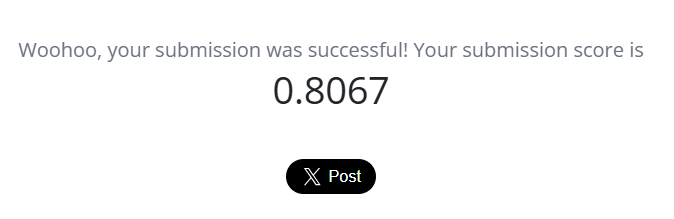

En este primer modelo donde hemos eliminado columnas que parecían a nuestro criterio no muy significativas, hemos conseguido una **precisión global del 80%**. 

Sin embargo, sería necesario intentar mejorar el modelo para aumentar su capacidad de detección para la clase "Functional needs repair", ya que no la predice igual de bien que las otras.

Pensamos en aplicar **SMOTE** para balancear las clases, pero en lugar de mejorar nuestro score lo empeoró levemente (pasando de un 0.8 a un 0.78).

A continuación, probaremos algunas técnicas adicionales de procesamiento de datos y ajuste del modelo, para poder evaluar después si esas mejoras llevan a un mejor equilibrio entre precisión y recuperación para todas las clases.

# Nuevo Modelo

## Preprocesamiento de datos

In [14]:
# Unimos las dos tablas
df_train = df_train.merge(y_train, on='id')

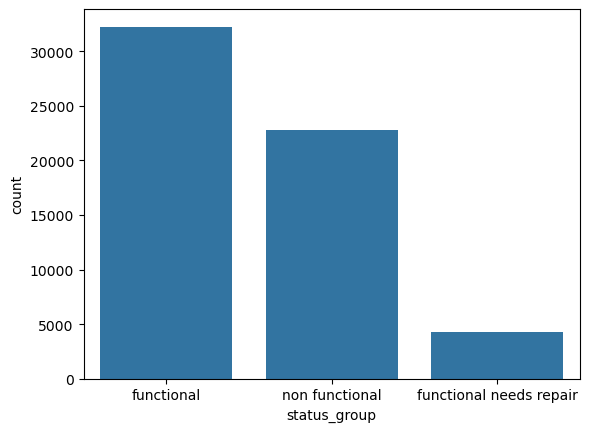

In [15]:
# Distribución de la variable objetivo
sns.countplot(x='status_group', data=df_train)
plt.show()

En caso de tener pocas variables, habría sido útil usar un **pairplot** para un análisis exploratorio inicial. Sin embargo, con tantos elementos resultaría poco informativo e ineficiente.

## Depuración de datos y tratamiento de variables

In [16]:
# Información general del conjunto de datos
df_train.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55763 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59398 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  war

Podemos ver que existen algunas variables que **no están correctamente tipificadas**, por lo que posteriormente las modificaremos.

In [17]:
# Observamos los valores únicos de cada variable
df_train.nunique()

amount_tsh                  98
date_recorded              356
funder                    1896
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37399
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           11
scheme_name               2695
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity

Comprobamos que la mayoría de las variables son multiclase y que existe una gran variación entre el número de elementos que compone cada una. Es decir, tal y como nos indica el enunciado, **el número de elementos de cada clase no está balanceado**.

In [18]:
# Observamos la distribución de los datos
df_train.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Nos fijamos sobre todo en métricas como el promedio y el valor máximo ya que nos muestran una imagen inicial sobre la forma de nuestros datos y nos dan una idea sobre su variabilidad (y existencia de posibles outliers).

In [19]:
df_train.select_dtypes(include=np.number).apply(lambda x: x.skew())

amount_tsh           57.807800
gps_height            0.462402
longitude            -4.191046
latitude             -0.152037
num_private          91.933750
region_code           3.173818
district_code         3.962045
population           12.660714
construction_year    -0.634928
dtype: float64

La distribución de las variables numéricas muestra que **varias de ellas están sesgadas**, como lo indican los valores altos de skewness. Podríamos aplicar transformaciones (como logaritmos) para reducir este sesgo antes de entrenar el modelo, especialmente si las distribuciones afectan significativamente el rendimiento del modelo.

Procedemos a modificar las variables que no están bien tipificadas. Recordamos que todos los cambios que hagamos debemos hacerlos también sobre df_test para no tener errores luego.

In [20]:
# Cambiamos 'construction_year', 'region_code' y 'district_code' a categóricas
to_factor = ['construction_year', 'region_code', 'district_code']
df_train[to_factor] = df_train[to_factor].astype('category')

In [21]:
# Pasamos primero 'date_recorded' a formato fecha
df_train['date_recorded'] = pd.to_datetime(df_train['date_recorded'])

# Extraemos el mes para poder analizar posteriormente patrones mensuales
df_train['month_recorded'] = df_train['date_recorded'].dt.month

# Convertimos el mes a categoría para el análisis
df_train['month_recorded'] = df_train['month_recorded'].astype('category')

# Eliminamos la columna original de la fecha
df_train = df_train.drop(columns=['date_recorded'])

In [22]:
#Test
df_test[to_factor] = df_test[to_factor].astype('category')
df_test['date_recorded'] = pd.to_datetime(df_test['date_recorded'])
df_test['month_recorded'] = df_test['date_recorded'].dt.month
df_test['month_recorded'] = df_test['month_recorded'].astype('category')
df_test = df_test.drop(columns=['date_recorded'])

También **eliminaremos 'num_private'** (es una variable que no sabemos lo que es) y comprobamos si podemos eliminar también 'scheme_name' y 'wpt_name' ya que solo contiene nombres del punto de agua y de quién lo ha operado.

In [23]:
df_train['scheme_name'].value_counts()

scheme_name
K                       682
Borehole                546
Chalinze wate           405
M                       400
DANIDA                  379
                       ... 
Mradi wa maji Vijini      1
Villagers                 1
Magundi water supply      1
Saadani Chumv             1
Mtawanya                  1
Name: count, Length: 2695, dtype: int64

In [24]:
df_train['wpt_name'].value_counts()

wpt_name
none                       3563
Shuleni                    1748
Zahanati                    830
Msikitini                   535
Kanisani                    323
                           ... 
Kwa Medadi                    1
Kwa Kubembeni                 1
Shule Ya Msingi Milanzi       1
Funua                         1
Kwa Mzee Lugawa               1
Name: count, Length: 37399, dtype: int64

Al tener más de 50 mil instancias y ver que el nombre de 'scheme_name' que más se repite lo hace solo 682 veces, no lo consideramos tan significativo como para dejarlo en nuestro modelo. 

En 'wpt_name' el nombre que más se repite es precisamente uno sin nombre, por lo que tampoco nos ofrece una información relevante.

'recorded_by' es el mismo para todas las variables, por lo que también lo podemos quitar. 

**Eliminamos 'num_private', 'scheme_name', 'wpt_name' y 'recorded_by**.

In [25]:
# Eliminamos las variables en df_train y df_test
df_train = df_train.drop(columns=['num_private', 'scheme_name', 'wpt_name', 'recorded_by'])
df_test = df_test.drop(columns=['num_private', 'scheme_name', 'wpt_name', 'recorded_by'])

In [26]:
# Dividimos como antes los datos en 'categóricos' y 'numéricos' para el preprocesamiento de datos
cat_var = df_train.select_dtypes(include=['object', 'category'])
num_var = df_train.select_dtypes(include=[np.number])

**Estudio de outliers**

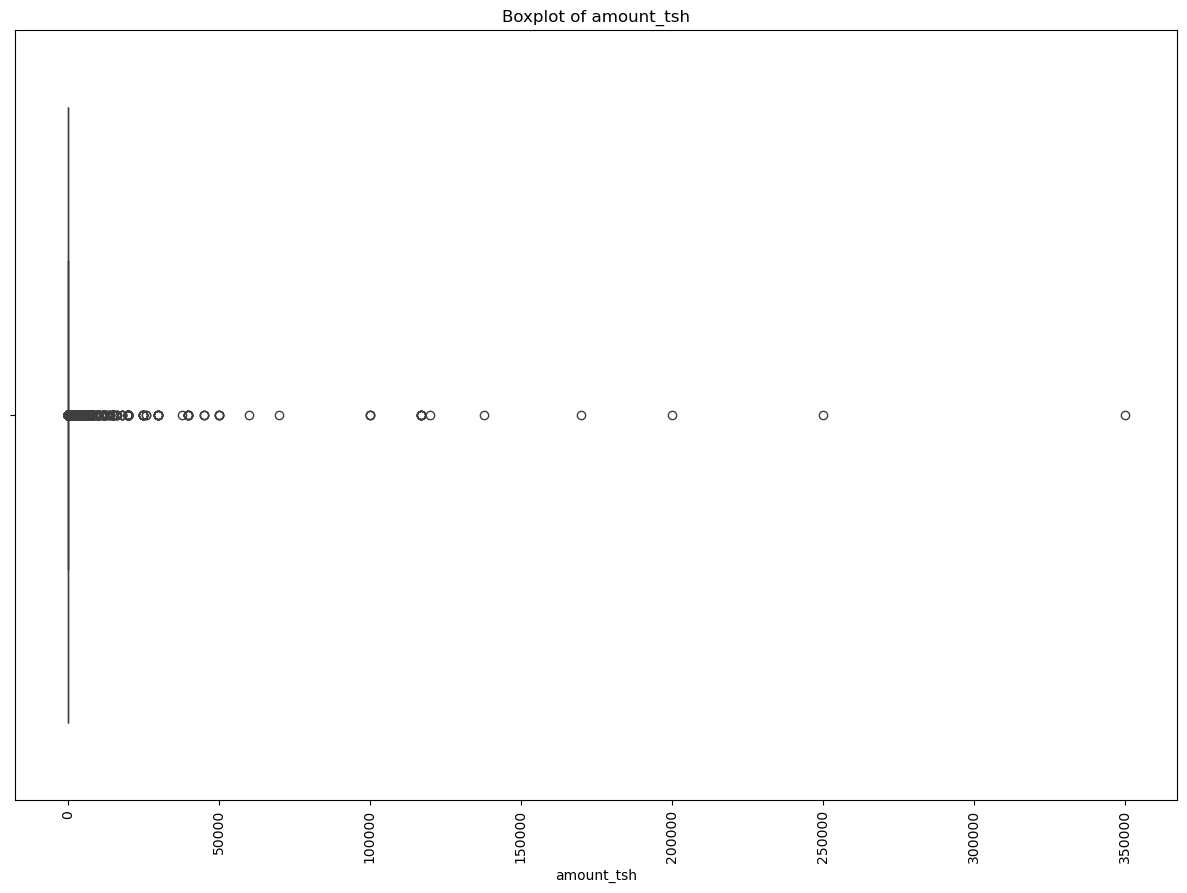

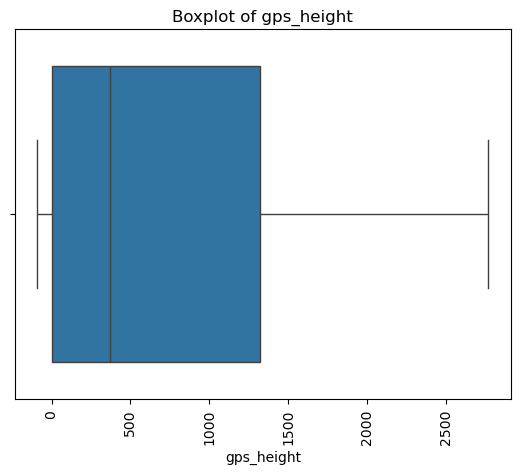

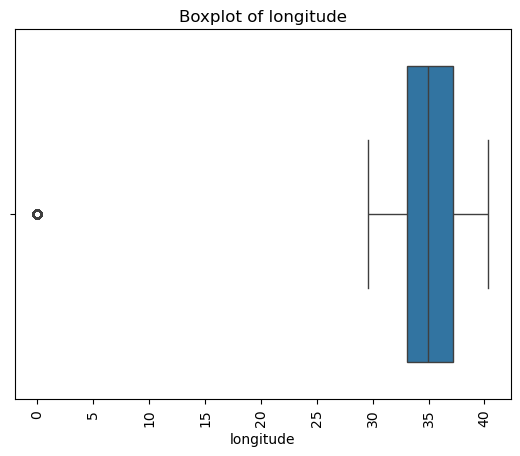

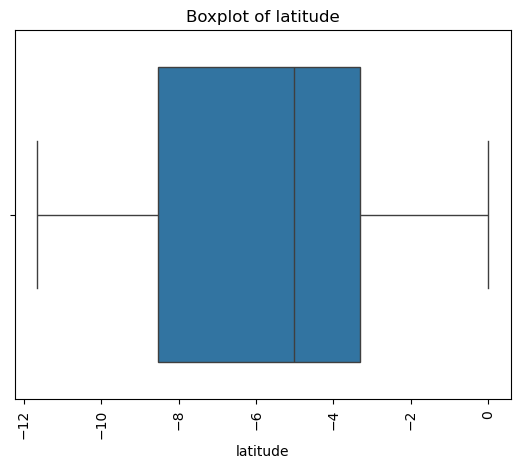

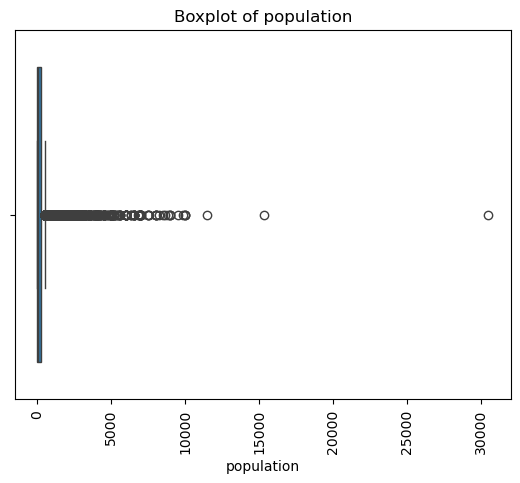

In [27]:
# Estudio de valores atípicos (outliers)
plt.figure(figsize=(15, 10))

for var in num_var:
    sns.boxplot(x=df_train[var])
    plt.xticks(rotation=90)
    plt.title(f'Boxplot of {var}')
    plt.show()

Vamos a hacer una prueba usando **IQR** para ver si podemos eliminar los outliers. En este caso no utilizaremos Z-score ya que nuestros datos contienen outliers extremos.

In [28]:
# Hacemos una prueba primero con una copia de las variables
num_var_iqr = num_var
cat_var_iqr = cat_var

# Eliminación de outliers usando IQR
Q1 = num_var_iqr.quantile(0.25)
Q3 = num_var_iqr.quantile(0.75)
IQR = Q3 - Q1

outliers = (num_var_iqr < (Q1 - 1.5 * IQR)) | (num_var_iqr > (Q3 + 1.5 * IQR))
num_var_iqr = num_var_iqr[~outliers.any(axis=1)]
df_train_iqr = num_var_iqr.join(cat_var_iqr, how='inner')

print(f"Número de datos restantes después de Z-Score: {df_train_iqr.shape[0]}")

Número de datos restantes después de Z-Score: 43302


De 59.400 datos eliminaríamos 16.098 (aproximadamente un 27,11% de los datos), por lo que **no nos planteamos esta opción**.

**Escalado de variables numéricas**

Procedemos a escalar las variables numéricas. En lugar de usar MinMaxScaler(), usaremos **RobustScaler()**, un escalador menos sensible a los outliers ya que utiliza los percentiles 25 y 75 para escalar los datos. Esto nos facilitará el proceso tanto para una posible imputación por KNN como para más tarde en obtener el modelo más adecuado.

In [29]:
scaler = RobustScaler()
df_train[num_var.columns] = scaler.fit_transform(num_var)
df_test[num_var.columns] = scaler.transform(df_test.select_dtypes(include=[np.number]))

**Gestión de missings**

In [30]:
# Comprobamos la existencia de missings
df_train.isnull().sum()

amount_tsh                  0
funder                   3637
gps_height                  0
installer                3655
longitude                   0
latitude                    0
basin                       0
subvillage                371
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
scheme_management        3878
permit                   3056
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint

En porcentaje:

In [31]:
df_train.apply(lambda x: x.isna().sum()/df_train.shape[0]*100)

amount_tsh               0.000000
funder                   6.122896
gps_height               0.000000
installer                6.153199
longitude                0.000000
latitude                 0.000000
basin                    0.000000
subvillage               0.624579
region                   0.000000
region_code              0.000000
district_code            0.000000
lga                      0.000000
ward                     0.000000
population               0.000000
public_meeting           5.612795
scheme_management        6.528620
permit                   5.144781
construction_year        0.000000
extraction_type          0.000000
extraction_type_group    0.000000
extraction_type_class    0.000000
management               0.000000
management_group         0.000000
payment                  0.000000
payment_type             0.000000
water_quality            0.000000
quality_group            0.000000
quantity                 0.000000
quantity_group           0.000000
source        

En principio, ninguna variable presenta un porcentaje de missings preocupante. Vamos a crear una variable **prop_missings** que cuente los missings por fila y lo ordenamos de manera descendente:

In [32]:
# Comprobamos la existencia de missings antes de imputar
df_train['prop_missings'] = df_train.apply(lambda x: x.isna().sum(),axis=1)
df_train.sort_values(by='prop_missings', ascending=False).head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,region_code,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,month_recorded,prop_missings
id,,,,,,,,,,,,,,,,,,,,,
65087,0.0,NaN,0.586697,NaN,0.345447,0.421461,Internal,Madukani,Arusha,2,...,unknown,unknown,unknown,other,unknown,hand pump,hand pump,functional,3,5
52485,0.0,NaN,0.504832,NaN,0.289351,0.281259,Internal,Makuyuni,Arusha,2,...,unknown,unknown,machine dbh,borehole,groundwater,other,other,non functional,3,5
19795,0.0,NaN,0.695850,NaN,0.452917,0.313147,Pangani,Moivaro,Arusha,2,...,unknown,unknown,unknown,other,unknown,communal standpipe,communal standpipe,functional,3,5
71282,0.0,NaN,0.697366,NaN,0.313255,0.306686,Internal,Engloriti,Arusha,2,...,unknown,unknown,unknown,other,unknown,communal standpipe,communal standpipe,functional,3,5
66687,0.0,NaN,0.708736,NaN,0.487207,0.366207,Internal,Tenki,Arusha,2,...,unknown,unknown,spring,spring,groundwater,communal standpipe,communal standpipe,functional,10,5


Tenemos un máximo de **5 NaN** por fila. Teniendo en cuenta que tenemos 36 variables, no parece un número significativo. Pasamos a verlo de forma gráfica ordenándolo por la variable que tiene un mayor porcentaje de missings:

<Axes: >

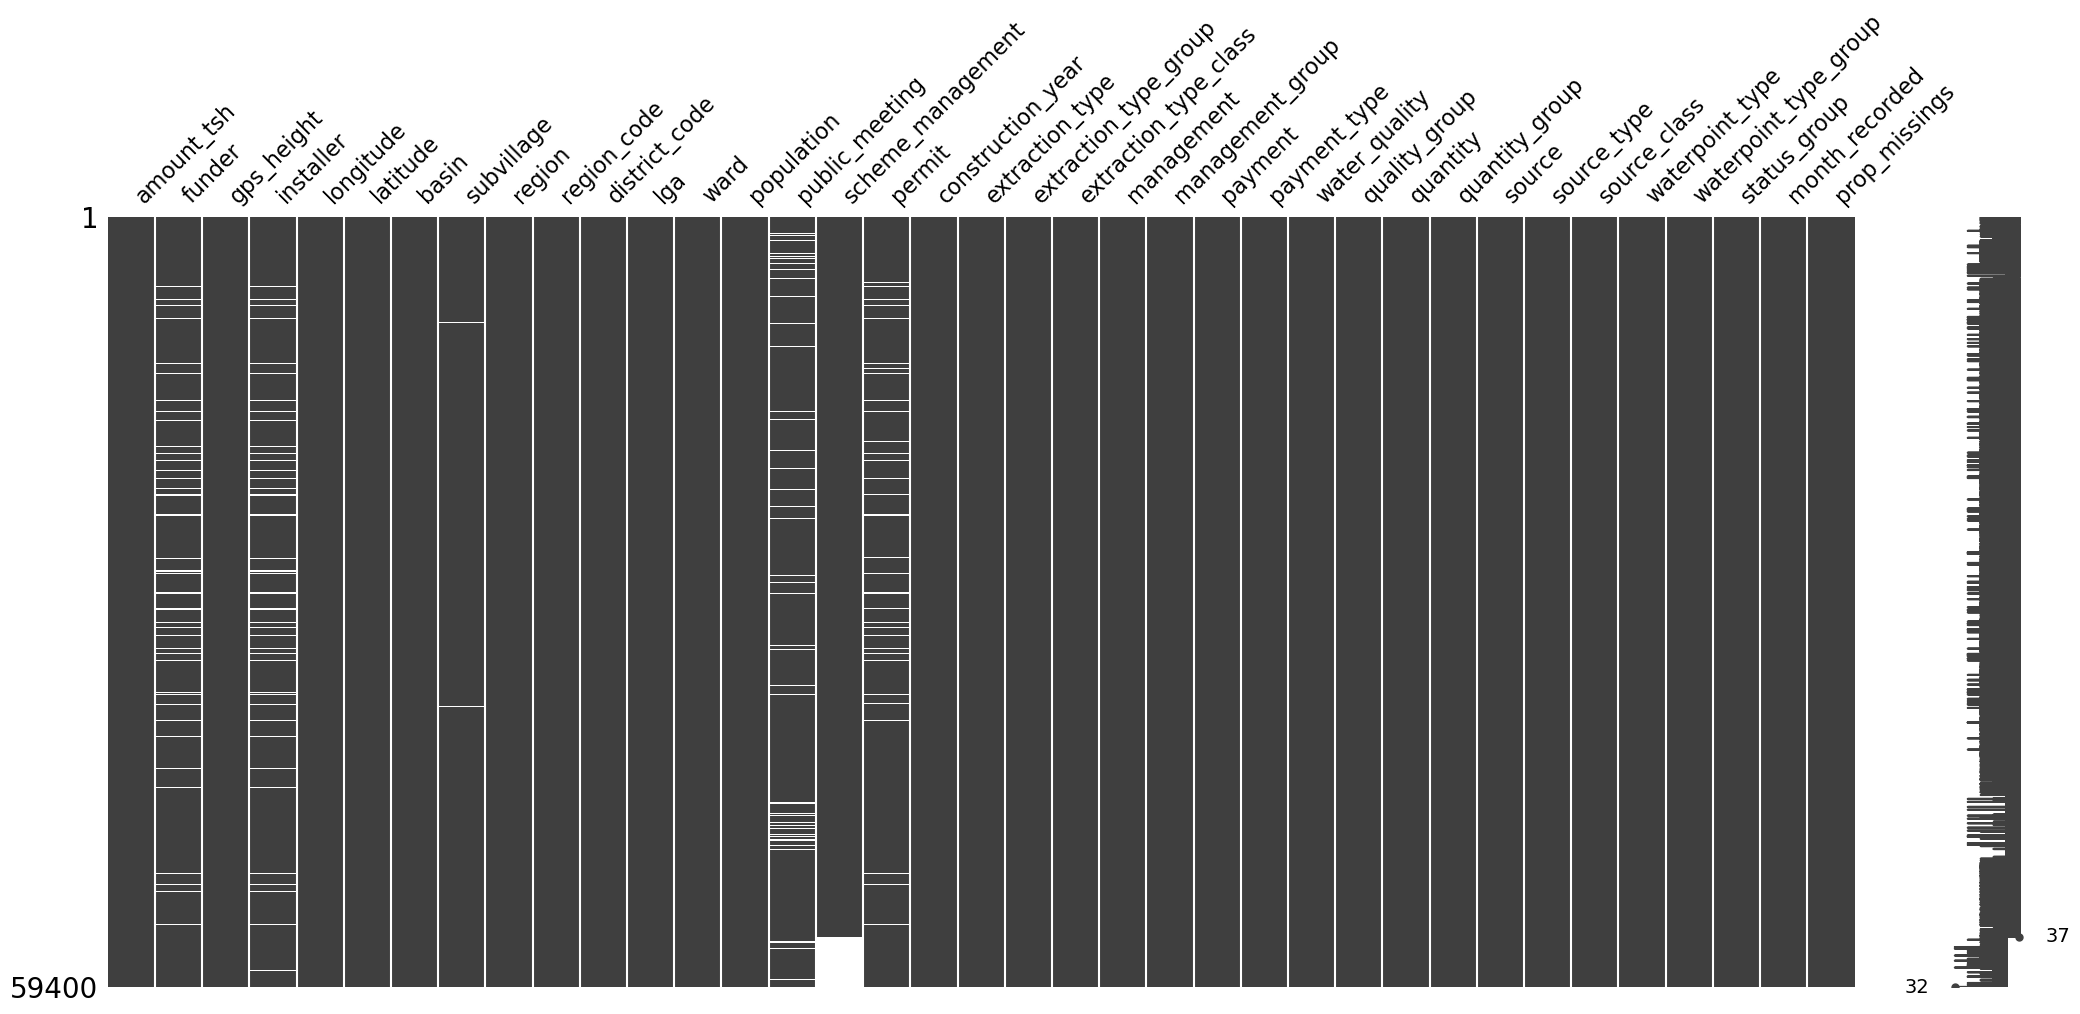

In [33]:
msno.matrix(df_train.sort_values(by='scheme_management'))

Valoramos la idea de eliminar las filas con NaN para ver si supone una pérdida significativa o no de datos:

In [34]:
# Cuánto quedaría de datos si eliminamos filas con NaN:
print('Estos son los datos de data:\n')
df_train.info()
print('\nEstos son los datos sin NaN:')
df_train_nan = df_train.dropna()
df_train_nan.info()

Estos son los datos de data:

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   amount_tsh             59400 non-null  float64 
 1   funder                 55763 non-null  object  
 2   gps_height             59400 non-null  float64 
 3   installer              55745 non-null  object  
 4   longitude              59400 non-null  float64 
 5   latitude               59400 non-null  float64 
 6   basin                  59400 non-null  object  
 7   subvillage             59029 non-null  object  
 8   region                 59400 non-null  object  
 9   region_code            59400 non-null  category
 10  district_code          59400 non-null  category
 11  lga                    59400 non-null  object  
 12  ward                   59400 non-null  object  
 13  population             59400 non-null  float64 
 14  public_me

Eliminando las filas con NaN pasamos de 59.400 entradas a 48.287 lo que supone una **pérdida del 18,71%**, esta opción tampoco es aceptable...

Sin embargo, en el gráfico de los NaN podemos ver cómo **'funder' e 'installer' parecen estar correlacionados**, pues presentan prácticamente los mismos missings. Vamos a verificar su correlación de missings mediante un heatmap:

<Axes: >

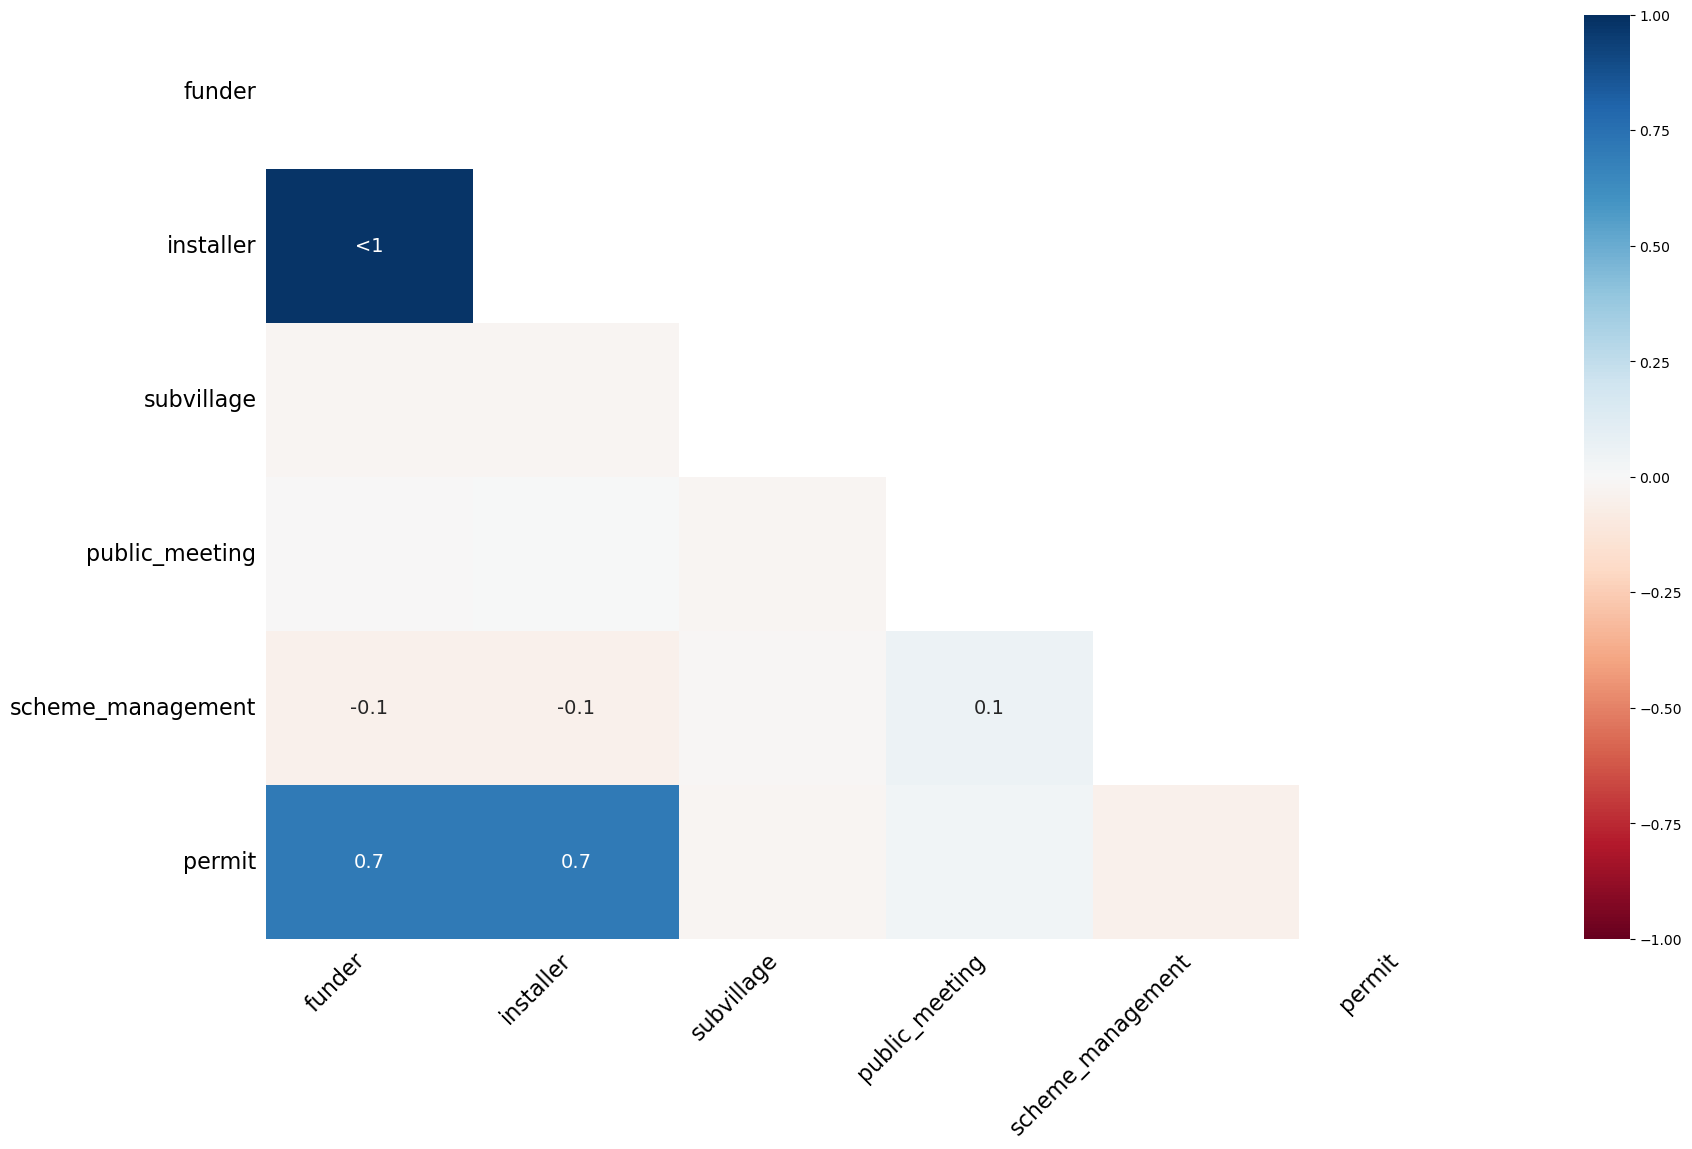

In [35]:
msno.heatmap(df_train)

In [36]:
df_train[['funder', 'installer']]

,funder,installer
id,,
69572,Roman,Roman
8776,Grumeti,GRUMETI
34310,Lottery Club,World vision
67743,Unicef,UNICEF
19728,Action In A,Artisan
...,...,...
60739,Germany Republi,CES
27263,Cefa-njombe,Cefa
37057,NaN,NaN


Tal y como sospechábamos, presentan una **fuerte correlación**, por lo que sería conveniente eliminar uno de ellos para evitar problemas de multicolinealidad. Asimismo, la variable **'permit'** también tiene un alto porcentaje de correlación, aunque no llega a ser tan alto como los anteriores.

Aprovechamos también para **eliminar la variable 'prop_missings'** en df_train que ya no necesitaremos.

In [37]:
#Eliminamos la variable 'funder'
df_train = df_train.drop(columns=['funder', 'prop_missings'])
df_test = df_test.drop(columns=['funder'])

**Imputación de missings**

Ahora, imputaremos los missings de las variables por el **método KNN para las variables numéricas** y la **moda para las categóricas**.

A través de la imputación por el **método de KNN**, se utilizarán los valores de los "vecinos más cercanos" para estimar el valor de aquellos registros con variables no informadas (NaN).

In [38]:
# Imputación de valores numéricos
imputer_knn = skl_imp.KNNImputer(n_neighbors=3)
imput_knn_imputed = pd.DataFrame(imputer_knn.fit_transform(num_var), columns=num_var.columns)
imput_knn_imputed.index = df_train.index
imput_knn_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   amount_tsh  59400 non-null  float64
 1   gps_height  59400 non-null  float64
 2   longitude   59400 non-null  float64
 3   latitude    59400 non-null  float64
 4   population  59400 non-null  float64
dtypes: float64(5)
memory usage: 4.7 MB


In [39]:
#Test
imput_knn_imputed_test = pd.DataFrame(imputer_knn.transform(df_test.select_dtypes(include=[np.number])), columns=num_var.columns)
imput_knn_imputed_test.index = df_test.index
imput_knn_imputed_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14850 entries, 50785 to 68707
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   amount_tsh  14850 non-null  float64
 1   gps_height  14850 non-null  float64
 2   longitude   14850 non-null  float64
 3   latitude    14850 non-null  float64
 4   population  14850 non-null  float64
dtypes: float64(5)
memory usage: 696.1 KB


A continuación, imputamos las variables categóricas por la **moda** (recordemos el sesgo que este método puede causar).

Teniendo en cuenta que hemos eliminado una variable, debemos actualizar la lista de variables categóricas antes de imputar. También debemos excluir la variable 'status_group' de cat_var antes de realizar la imputación en df_test, ya que los datos de prueba no tienen esta variable. Posteriormente la volveremos a unir.

In [40]:
# Actualizamos la lista de variables categóricas
cat_var = df_train.select_dtypes(include=['object', 'category'])

# Separamos 'status_group' en df_train y df_test
X_train = df_train.drop(columns=['status_group'])
cat_var_ = X_train.select_dtypes(include=['object', 'category'])
X_test = df_test

In [41]:
# Imputación de variables categóricas
imputer_moda = skl_imp.SimpleImputer(strategy='most_frequent', missing_values=np.nan)
imput_moda = pd.DataFrame(imputer_moda.fit_transform(cat_var_), columns=cat_var_.columns)
imput_moda.index = df_train.index
imput_moda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   installer              59400 non-null  object
 1   basin                  59400 non-null  object
 2   subvillage             59400 non-null  object
 3   region                 59400 non-null  object
 4   region_code            59400 non-null  object
 5   district_code          59400 non-null  object
 6   lga                    59400 non-null  object
 7   ward                   59400 non-null  object
 8   public_meeting         59400 non-null  object
 9   scheme_management      59400 non-null  object
 10  permit                 59400 non-null  object
 11  construction_year      59400 non-null  object
 12  extraction_type        59400 non-null  object
 13  extraction_type_group  59400 non-null  object
 14  extraction_type_class  59400 non-null  object
 15  management          

In [42]:
#Test
imput_moda_test = pd.DataFrame(imputer_moda.transform(df_test.select_dtypes(include=['object', 'category'])), columns=cat_var_.columns)
imput_moda_test.index = df_test.index
imput_moda_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14850 entries, 50785 to 68707
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   installer              14850 non-null  object
 1   basin                  14850 non-null  object
 2   subvillage             14850 non-null  object
 3   region                 14850 non-null  object
 4   region_code            14850 non-null  object
 5   district_code          14850 non-null  object
 6   lga                    14850 non-null  object
 7   ward                   14850 non-null  object
 8   public_meeting         14850 non-null  object
 9   scheme_management      14850 non-null  object
 10  permit                 14850 non-null  object
 11  construction_year      14850 non-null  object
 12  extraction_type        14850 non-null  object
 13  extraction_type_group  14850 non-null  object
 14  extraction_type_class  14850 non-null  object
 15  management          

In [43]:
# Volvemos a añadir la columna 'status_group' a df_train imputado
imput_moda['status_group'] = df_train['status_group']

# Sobrescribimos df_train y df_test con las versiones imputadas
df_train = imput_moda
df_test = imput_moda_test

Observamos finalmente nuestros datos tras las imputaciones:

In [44]:
total_imputaciones = imput_knn_imputed.join(imput_moda, how='inner', on='id')
total_imputaciones

,amount_tsh,gps_height,longitude,latitude,population,installer,basin,subvillage,region,region_code,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month_recorded,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,1390.0,34.938093,-9.856322,109.0,Roman,Lake Nyasa,Mnyusi B,Iringa,11,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,3,functional
8776,0.0,1399.0,34.698766,-2.147466,280.0,GRUMETI,Lake Victoria,Nyamara,Mara,20,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,3,functional
34310,25.0,686.0,37.460664,-3.821329,250.0,World vision,Pangani,Majengo,Manyara,21,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2,functional
67743,0.0,263.0,38.486161,-11.155298,58.0,UNICEF,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1,non functional
19728,0.0,0.0,31.130847,-1.825359,0.0,Artisan,Lake Victoria,Kyanyamisa,Kagera,18,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,7,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,10.0,1210.0,37.169807,-3.253847,125.0,CES,Pangani,Kiduruni,Kilimanjaro,3,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,5,functional
27263,4700.0,1212.0,35.249991,-9.070629,56.0,Cefa,Rufiji,Igumbilo,Iringa,11,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,5,functional
37057,0.0,0.0,34.017087,-8.750434,0.0,DWE,Rufiji,Madungulu,Mbeya,12,...,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,4,functional


In [45]:
#Test
total_imputaciones_test = imput_knn_imputed_test.join(imput_moda_test, how='inner', on='id', lsuffix='_knn', rsuffix='_moda')
total_imputaciones_test

,amount_tsh,gps_height,longitude,latitude,population,installer,basin,subvillage,region,region_code,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month_recorded
id,,,,,,,,,,,,,,,,,,,,,
50785,0.0,1.233276,0.093457,0.184468,1.376744,DMDD,Internal,Magoma,Manyara,21,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,2
51630,0.0,0.909608,0.427580,0.328391,1.279070,DWE,Pangani,Kimnyak,Arusha,2,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2
17168,0.0,0.908092,-0.034462,0.003309,2.209302,DWE,Internal,Msatu,Singida,13,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,2
45559,0.0,-0.077317,0.770370,-0.843246,1.046512,FINN WATER,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,...,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,1
49871,25.0,0.675384,0.023821,-1.136994,0.162791,BRUDER,Ruvuma / Southern Coast,Losonga,Ruvuma,10,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39307,0.0,-0.253932,0.964747,-0.299406,-0.023256,Da,Wami / Ruvu,Yombo,Pwani,6,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,2
18990,50.0,-0.279704,0.622032,-0.063061,13.651163,HIAP,Pangani,Mkondoa,Tanga,4,...,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,3
28749,0.0,0.839113,-0.041325,0.083615,0.813953,DWE,Internal,Juhudi,Singida,13,...,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,3


In [46]:
# Nueva división 
cat_var_ = total_imputaciones.select_dtypes(include=['object', 'category'])
num_var_ = total_imputaciones.select_dtypes(include=[np.number])

**Selección de categorías**

Seleccionamos aquellas categorías compuestas por más de 5 elementos para trabajar con ellas.

In [47]:
# Selección de categorías
df_train.nunique()
a = cat_var_.nunique()
a[a>5]

installer                 2145
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
scheme_management           11
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
payment                      7
payment_type                 7
water_quality                8
quality_group                6
source                      10
source_type                  7
waterpoint_type              7
waterpoint_type_group        6
month_recorded              12
dtype: int64

Con la siguiente función, lo que buscamos es reemplazar por "other" todos aquellos elementos de cada categoría que no lleguen al umbral mínimo de representación (que definiremos de forma individual para cada variable), con el objetivo de reducir el número de elementos.

In [48]:
def replace_categories_by_percentage(df, column, threshold_percentage):
    """
    Reemplaza las categorías que no alcanzan un umbral en porcentaje en una columna de un DataFrame con 'other'.
    
    Parámetros:
    - df: DataFrame de pandas.
    - column: el nombre de la columna en la que se reemplazarán las categorías.
    - threshold_percentage: el umbral mínimo de porcentaje para mantener una categoría (entre 0 y 1).
    
    Devuelve:
    - El DataFrame modificado con las categorías menos frecuentes reemplazadas por 'other'.
    """
    # Contamos la frecuencia de cada categoría
    category_counts = df[column].value_counts(normalize=True)  # Calcula el porcentaje
    
    # Identificamos las categorías que no cumplen con el umbral de porcentaje
    categories_to_replace = category_counts[category_counts < threshold_percentage].index
    
    # Reemplazamos las categorías por "Other"
    df[column] = df[column].apply(lambda x: 'other' if x in categories_to_replace else x)
    
    return df

Primero, iremos viendo el peso de cada elemento dentro de nuestra base de datos total. Repetiremos este paso para cada variable categórica sustituyendo simplemente el nombre de la variable. Por ejemplo, empezaremos con la variable 'installer':

In [49]:
total_imputaciones['installer'].value_counts()/len(total_imputaciones)

installer
DWE                0.354495
Government         0.030724
RWE                0.020303
Commu              0.017845
DANIDA             0.017677
                     ...   
Wizara  ya maji    0.000017
TWESS              0.000017
Nasan workers      0.000017
R                  0.000017
SELEPTA            0.000017
Name: count, Length: 2145, dtype: float64

Aquí podríamos marcar el threshold en 0.015 viendo la distribución de los elementos que componen la variable 'installer'. Actualizamos la base de datos 'total_imputaciones' con nuestra fórmula que reemplazará todos aquellos elementos que no lleguen a este umbral por 'other'.

In [50]:
# Installer
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'installer', 0.015)

Recordamos que todos estos cambios también tenemos que ir haciéndolos en total_imputaciones_test.

In [51]:
total_imputaciones_test['installer'] = total_imputaciones_test['installer'].apply(lambda x: x if x in total_imputaciones['installer'].unique() else 'other')

Esta función me deja en total_imputaciones_test los valores únicos que hemos dejado en total_imputaciones y reemplaza de la misma forma por 'other' los que hemos categorizado como 'other' a través de la función.

In [52]:
# Basin
total_imputaciones['basin'].value_counts()/len(total_imputaciones)

basin
Lake Victoria              0.172525
Pangani                    0.150505
Rufiji                     0.134276
Internal                   0.131061
Lake Tanganyika            0.108283
Wami / Ruvu                0.100791
Lake Nyasa                 0.085606
Ruvuma / Southern Coast    0.075640
Lake Rukwa                 0.041313
Name: count, dtype: float64

In [53]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'basin', 0) #La dejamos entera
total_imputaciones_test['basin'] = total_imputaciones_test['basin'].apply(lambda x: x if x in total_imputaciones['basin'].unique() else 'other')

In [54]:
# Subvillage
total_imputaciones['subvillage'].value_counts()/len(total_imputaciones)

subvillage
Madukani        0.014798
Shuleni         0.008519
Majengo         0.008451
Kati            0.006279
Mtakuja         0.004411
                  ...   
Kipompo         0.000017
Chanyamilima    0.000017
Ikalime         0.000017
Kemagaka        0.000017
Kikatanyemba    0.000017
Name: count, Length: 19287, dtype: float64

**Eliminamos esta variable** ya que el elemento que más se repite es solo un 1% de las veces.

In [55]:
total_imputaciones = total_imputaciones.drop(columns=['subvillage'])
total_imputaciones_test = total_imputaciones_test.drop(columns=['subvillage'])

In [56]:
# Region
total_imputaciones['region'].value_counts()/len(total_imputaciones)

region
Iringa           0.089125
Shinyanga        0.083872
Mbeya            0.078098
Kilimanjaro      0.073721
Morogoro         0.067441
Arusha           0.056397
Kagera           0.055825
Mwanza           0.052222
Kigoma           0.047407
Ruvuma           0.044444
Pwani            0.044360
Tanga            0.042879
Dodoma           0.037054
Singida          0.035236
Mara             0.033148
Tabora           0.032980
Rukwa            0.030438
Mtwara           0.029125
Manyara          0.026650
Lindi            0.026027
Dar es Salaam    0.013552
Name: count, dtype: float64

In [57]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'region', 0) #Entera de momento
total_imputaciones_test['region'] = total_imputaciones_test['region'].apply(lambda x: x if x in total_imputaciones['region'].unique() else 'other')

También **eliminaremos la variable 'region_code'**, ya que nos ofrece la misma información que 'region' pero esta última está formada por menos variables.

In [58]:
total_imputaciones = total_imputaciones.drop(columns=['region_code'])
total_imputaciones_test = total_imputaciones_test.drop(columns=['region_code'])

In [59]:
# District_code
total_imputaciones['district_code'].value_counts()/len(total_imputaciones)

district_code
1     0.205438
2     0.188098
3     0.168316
4     0.151498
5     0.073333
6     0.068586
7     0.056279
8     0.017559
30    0.016751
33    0.014714
53    0.012542
43    0.008502
13    0.006582
23    0.004933
63    0.003283
62    0.001835
60    0.001061
0     0.000387
80    0.000202
67    0.000101
Name: count, dtype: float64

In [60]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'district_code', 0.1)
total_imputaciones_test['district_code'] = total_imputaciones_test['district_code'].apply(lambda x: x if x in total_imputaciones['district_code'].unique() else 'other')

In [61]:
# Lga
total_imputaciones['lga'].value_counts()/len(total_imputaciones)

lga
Njombe          0.042138
Arusha Rural    0.021077
Moshi Rural     0.021061
Bariadi         0.019815
Rungwe          0.018620
                  ...   
Moshi Urban     0.001330
Kigoma Urban    0.001195
Arusha Urban    0.001061
Lindi Urban     0.000354
Nyamagana       0.000017
Name: count, Length: 125, dtype: float64

In [62]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'lga', 0.015)
total_imputaciones_test['lga'] = total_imputaciones_test['lga'].apply(lambda x: x if x in total_imputaciones['lga'].unique() else 'other')

In [63]:
# Ward
total_imputaciones['ward'].value_counts()/len(total_imputaciones)

ward
Igosi              0.005168
Imalinyi           0.004242
Siha Kati          0.003906
Mdandu             0.003889
Nduruma            0.003653
                     ...   
Uchindile          0.000017
Thawi              0.000017
Uwanja wa Ndege    0.000017
Izia               0.000017
Kinungu            0.000017
Name: count, Length: 2092, dtype: float64

Esta variable **también la eliminamos** por los mismos motivos que 'subvillage'.

In [64]:
total_imputaciones = total_imputaciones.drop(columns=['ward'])
total_imputaciones_test = total_imputaciones_test.drop(columns=['ward'])

In [65]:
# Scheme_management 
total_imputaciones['scheme_management'].value_counts()/len(total_imputaciones)

scheme_management
VWC                 0.684697
WUG                 0.087643
Water authority     0.053081
WUA                 0.048535
Water Board         0.046263
Parastatal          0.028283
Private operator    0.017896
Company             0.017862
Other               0.012896
SWC                 0.001633
Trust               0.001212
Name: count, dtype: float64

In [66]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'scheme_management', 0.015)
total_imputaciones_test['scheme_management'] = total_imputaciones_test['scheme_management'].apply(lambda x: x if x in total_imputaciones['scheme_management'].unique() else 'other')

In [67]:
# Construction_year 
total_imputaciones['construction_year'].value_counts()/len(total_imputaciones)

construction_year
0       0.348636
2010    0.044529
2008    0.043990
2009    0.042643
2000    0.035202
2007    0.026717
2006    0.024764
2003    0.021650
2011    0.021145
2004    0.018906
2012    0.018249
2002    0.018098
1978    0.017458
1995    0.017071
2005    0.017020
1999    0.016481
1998    0.016263
1990    0.016061
1985    0.015909
1980    0.013653
1996    0.013653
1984    0.013114
1982    0.012525
1994    0.012424
1972    0.011919
1974    0.011380
1997    0.010842
1992    0.010774
1993    0.010236
2001    0.009091
1988    0.008771
1983    0.008215
1975    0.007357
1986    0.007306
1976    0.006970
1970    0.006919
1991    0.005455
1989    0.005320
1987    0.005084
1981    0.004007
1977    0.003401
1979    0.003232
1973    0.003098
2013    0.002963
1971    0.002441
1960    0.001717
1967    0.001481
1963    0.001431
1968    0.001296
1969    0.000993
1964    0.000673
1962    0.000505
1961    0.000354
1965    0.000320
1966    0.000286
Name: count, dtype: float64

In [68]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'construction_year', 0.02)
total_imputaciones_test['construction_year'] = total_imputaciones_test['construction_year'].apply(lambda x: x if x in total_imputaciones['construction_year'].unique() else 'other')

In [69]:
# Extraction_type, extraction_type_group y extraction_type_class
(total_imputaciones['extraction_type']+ " / " +total_imputaciones['extraction_type_group']+ " / " + total_imputaciones['extraction_type_class']).value_counts()

gravity / gravity / gravity                              26780
nira/tanira / nira/tanira / handpump                      8154
other / other / other                                     6430
submersible / submersible / submersible                   4764
swn 80 / swn 80 / handpump                                3670
mono / mono / motorpump                                   2865
india mark ii / india mark ii / handpump                  2400
afridev / afridev / handpump                              1770
ksb / submersible / submersible                           1415
other - rope pump / rope pump / rope pump                  451
other - swn 81 / other handpump / handpump                 229
windmill / wind-powered / wind-powered                     117
india mark iii / india mark iii / handpump                  98
cemo / other motorpump / motorpump                          90
other - play pump / other handpump / handpump               85
walimi / other handpump / handpump                     

Con respecto a estas tres variables, podemos ver que son bastante similares. **Decidimos quedarnos con 'extraction_type_group'**, ya que parece coindicir siempre con alguno de los otros 2.

In [70]:
# Extraction_type_group 
total_imputaciones['extraction_type_group'].value_counts()/len(total_imputaciones)

extraction_type_group
gravity            0.450842
nira/tanira        0.137273
other              0.108249
submersible        0.104024
swn 80             0.061785
mono               0.048232
india mark ii      0.040404
afridev            0.029798
rope pump          0.007593
other handpump     0.006128
other motorpump    0.002054
wind-powered       0.001970
india mark iii     0.001650
Name: count, dtype: float64

In [71]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'extraction_type_group', 0.1)
total_imputaciones_test['extraction_type_group'] = total_imputaciones_test['extraction_type_group'].apply(lambda x: x if x in total_imputaciones['extraction_type_group'].unique() else 'other')

In [72]:
# Eliminamos las otras dos 
total_imputaciones = total_imputaciones.drop(columns=['extraction_type', 'extraction_type_class'])
total_imputaciones_test = total_imputaciones_test.drop(columns=['extraction_type', 'extraction_type_class'])

In [73]:
# Management 
total_imputaciones['management'].value_counts()/len(total_imputaciones)

management
vwc                 0.681936
wug                 0.109680
water board         0.049377
wua                 0.042677
private operator    0.033182
parastatal          0.029764
water authority     0.015219
other               0.014209
company             0.011532
unknown             0.009444
other - school      0.001667
trust               0.001313
Name: count, dtype: float64

In [74]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'management', 0.03)
total_imputaciones_test['management'] = total_imputaciones_test['management'].apply(lambda x: x if x in total_imputaciones['management'].unique() else 'other')

In [75]:
# Payment y payment_type
(total_imputaciones['payment']+ "/" + total_imputaciones['payment_type']).value_counts() 

never pay/never pay                 25348
pay per bucket/per bucket            8985
pay monthly/monthly                  8300
unknown/unknown                      8157
pay when scheme fails/on failure     3914
pay annually/annually                3642
other/other                          1054
Name: count, dtype: int64

Aquí también nos sobra una, ya que las dos tienen el mismo número de categorías. **Decidimos quedarnos con 'payment'**.

In [76]:
# Payment 
total_imputaciones['payment'].value_counts()/len(total_imputaciones)

payment
never pay                0.426734
pay per bucket           0.151263
pay monthly              0.139731
unknown                  0.137323
pay when scheme fails    0.065892
pay annually             0.061313
other                    0.017744
Name: count, dtype: float64

In [77]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'payment', 0) #También entera
total_imputaciones_test['payment'] = total_imputaciones_test['payment'].apply(lambda x: x if x in total_imputaciones['payment'].unique() else 'other')

In [78]:
# Eliminamos la otra
total_imputaciones = total_imputaciones.drop(columns=['payment_type'])
total_imputaciones_test = total_imputaciones_test.drop(columns=['payment_type'])

In [79]:
# Water_quality y quality_group
(total_imputaciones['water_quality']+ " / " +total_imputaciones['quality_group']).value_counts()

soft / good                      50818
salty / salty                     4856
unknown / unknown                 1876
milky / milky                      804
coloured / colored                 490
salty abandoned / salty            339
fluoride / fluoride                200
fluoride abandoned / fluoride       17
Name: count, dtype: int64

En este caso, **nos quedamos con 'quality_group'** porque tiene menos variables.

In [80]:
# Quality_group
total_imputaciones['quality_group'].value_counts()/len(total_imputaciones)

quality_group
good        0.855522
salty       0.087458
unknown     0.031582
milky       0.013535
colored     0.008249
fluoride    0.003653
Name: count, dtype: float64

In [81]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'quality_group', 0.01)
total_imputaciones_test['quality_group'] = total_imputaciones_test['quality_group'].apply(lambda x: x if x in total_imputaciones['quality_group'].unique() else 'other')

In [82]:
# Eliminamos la otra
total_imputaciones = total_imputaciones.drop(columns=['water_quality'])
total_imputaciones_test = total_imputaciones_test.drop(columns=['water_quality'])

In [83]:
# Source y source_type
(total_imputaciones['source']+ " / " +total_imputaciones['source_type']).value_counts()

spring / spring                                17021
shallow well / shallow well                    16824
machine dbh / borehole                         11075
river / river/lake                              9612
rainwater harvesting / rainwater harvesting     2295
hand dtw / borehole                              874
lake / river/lake                                765
dam / dam                                        656
other / other                                    212
unknown / other                                   66
Name: count, dtype: int64

**Nos quedamos con 'source_type'** por lo mismo, para no tener tantas variables al sacar dummies.

In [84]:
# Source_type
total_imputaciones['source_type'].value_counts()/len(total_imputaciones)

source_type
spring                  0.286549
shallow well            0.283232
borehole                0.201162
river/lake              0.174697
rainwater harvesting    0.038636
dam                     0.011044
other                   0.004680
Name: count, dtype: float64

In [85]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'source_type', 0.1)
total_imputaciones_test['source_type'] = total_imputaciones_test['source_type'].apply(lambda x: x if x in total_imputaciones['source_type'].unique() else 'other')

In [86]:
# Eliminamos la otra
total_imputaciones = total_imputaciones.drop(columns=['source'])
total_imputaciones_test = total_imputaciones_test.drop(columns=['source'])

In [87]:
# Waterpoint_type y waterpoint_type_group
(total_imputaciones['waterpoint_type']+ " / " + total_imputaciones['waterpoint_type_group']).value_counts()

communal standpipe / communal standpipe             28522
hand pump / hand pump                               17488
other / other                                        6380
communal standpipe multiple / communal standpipe     6103
improved spring / improved spring                     784
cattle trough / cattle trough                         116
dam / dam                                               7
Name: count, dtype: int64

**Nos quedamos con 'waterpoint_type_group'**.

In [88]:
# Waterpoint_type_group
total_imputaciones['waterpoint_type_group'].value_counts()/len(total_imputaciones)

waterpoint_type_group
communal standpipe    0.582912
hand pump             0.294411
other                 0.107407
improved spring       0.013199
cattle trough         0.001953
dam                   0.000118
Name: count, dtype: float64

In [89]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'waterpoint_type_group', 0.1)
total_imputaciones_test['waterpoint_type_group'] = total_imputaciones_test['waterpoint_type_group'].apply(lambda x: x if x in total_imputaciones['waterpoint_type_group'].unique() else 'other')

In [90]:
# Eliminamos la otra
total_imputaciones = total_imputaciones.drop(columns=['waterpoint_type'])
total_imputaciones_test = total_imputaciones_test.drop(columns=['waterpoint_type'])

In [91]:
# Month_recorded
total_imputaciones['month_recorded'].value_counts()/len(total_imputaciones)

month_recorded
3     0.301953
2     0.208788
7     0.116633
1     0.106970
10    0.092020
4     0.066835
8     0.056633
11    0.022710
12    0.010455
6     0.005825
5     0.005657
9     0.005522
Name: count, dtype: float64

In [92]:
total_imputaciones = replace_categories_by_percentage(total_imputaciones, 'month_recorded', 0.1)
total_imputaciones_test['month_recorded'] = total_imputaciones_test['month_recorded'].apply(lambda x: x if x in total_imputaciones['month_recorded'].unique() else 'other')

Por lo tanto, así se quedarían nuestras variables categóricas:

In [93]:
cat_var_ = total_imputaciones.select_dtypes(include=['object', 'category']) # Actualizamos lista
cat_var_.nunique()

installer                 7
basin                     9
region                   21
district_code             5
lga                      13
public_meeting            2
scheme_management         9
permit                    2
construction_year        10
extraction_type_group     4
management                6
management_group          5
payment                   7
quality_group             5
quantity                  5
quantity_group            5
source_type               5
source_class              3
waterpoint_type_group     3
month_recorded            5
status_group              3
dtype: int64

## Análisis de las variables frente a la variable objetivo "status_group"

Para evaluar la relación de cada variable con nuestra variable objetivo "status_group" primero vamos a usar la **V de Cramer** para que nos muestre en un gráfico los elementos, de mayor a menor, según su grado de relación con la variable objetivo. 

In [94]:
nivel_significancia =0.05

# Con los missings imputados
chi2_test = lambda col: stats.chi2_contingency(pd.crosstab(total_imputaciones['status_group'], imput_moda[col]))[:2]

resultados = imput_moda.columns.to_series().apply(chi2_test)

resultados_df = pd.DataFrame(resultados.tolist(), index=resultados.index, columns=['chi2', 'p_valor'])
resultados_df['resultado'] = resultados_df['p_valor'].apply(lambda p: 'Rechazar H0' if p < nivel_significancia else 'No rechazar H0')
print(resultados_df)

                                chi2        p_valor    resultado
installer               14709.140389   0.000000e+00  Rechazar H0
basin                    1921.034226   0.000000e+00  Rechazar H0
subvillage              55188.651583   0.000000e+00  Rechazar H0
region                   4794.631126   0.000000e+00  Rechazar H0
region_code              5157.385233   0.000000e+00  Rechazar H0
district_code            1673.521277   0.000000e+00  Rechazar H0
lga                     11529.910639   0.000000e+00  Rechazar H0
ward                    26144.961185   0.000000e+00  Rechazar H0
public_meeting            286.322739   6.695874e-63  Rechazar H0
scheme_management        1968.443765   0.000000e+00  Rechazar H0
permit                     68.211851   1.541646e-15  Rechazar H0
construction_year        4098.405795   0.000000e+00  Rechazar H0
extraction_type          7365.638498   0.000000e+00  Rechazar H0
extraction_type_group    7265.845618   0.000000e+00  Rechazar H0
extraction_type_class    

In [95]:
# Código para calcular el vcramer de variables categóricas con el chi2
def Cramer_Categoricas(df, target_col):
    chi2_values = []
    p_values = []
    cramers_v_values = []
    contingency_table= []
    for col in df.columns:
        contingency_table = pd.crosstab(df[col],target_col)
        chi2, p, _, _ = stats.chi2_contingency(contingency_table)
        
        n = contingency_table.sum().sum()
        k = contingency_table.shape[1]
        r = contingency_table.shape[0]
        
        cramers_v = np.sqrt(chi2 / (n * min(k-1, r-1)))
        
        chi2_values.append((col, chi2))
        p_values.append((col, p))
        cramers_v_values.append((col, cramers_v, n, k, r))
    
    chi2_df = pd.DataFrame(chi2_values, columns=['feature', 'chi2'])
    p_df = pd.DataFrame(p_values, columns=['feature', 'p_value'])
    cramers_v_df = pd.DataFrame(cramers_v_values, columns=['feature', 'cramers_v', 'n', 'k', 'r'])

    return chi2_df, p_df, cramers_v_df

                  feature  cramers_v      n  k      r
29           status_group   1.000000  59400  3      3
2              subvillage   0.681580  59400  3  19287
7                    ward   0.469122  59400  3   2092
0               installer   0.351873  59400  3   2145
6                     lga   0.311533  59400  3    125
22         quantity_group   0.309240  59400  3      5
21               quantity   0.309240  59400  3      5
26        waterpoint_type   0.250426  59400  3      7
12        extraction_type   0.248999  59400  3     18
13  extraction_type_group   0.247306  59400  3     13
14  extraction_type_class   0.241544  59400  3      7
27  waterpoint_type_group   0.226873  59400  3      6
4             region_code   0.208356  59400  3     27
3                  region   0.200895  59400  3     21
11      construction_year   0.185737  59400  3     55
18           payment_type   0.182704  59400  3      7
17                payment   0.182704  59400  3      7
23                 source   

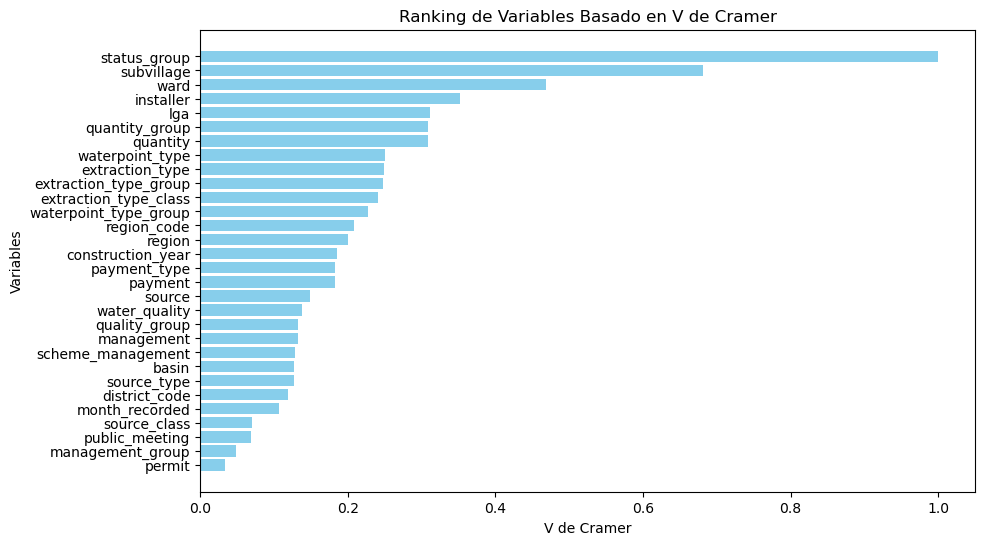

In [96]:
chi2_df, p_df, cramers_v_df = Cramer_Categoricas(imput_moda,total_imputaciones['status_group'])
cramers_v_df = cramers_v_df.sort_values(by='cramers_v', ascending=False)
print(cramers_v_df)
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(cramers_v_df['feature'], cramers_v_df['cramers_v'], color='skyblue')
plt.xlabel('V de Cramer')
plt.ylabel('Variables')
plt.title('Ranking de Variables Basado en V de Cramer')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar el ranking en orden descendente
plt.show()

Compararemos estos resultados con los siguientes gráficos que también nos muestran la relación de cada variable con nuestra variable objetivo, pero en este caso diferenciando entre 'functional', 'non functional' y 'functional needs repair'.

In [97]:
# Cambiamos las variables 'region_code', 'disctrict_code' y 'construction_year' a strings para poder graficar
for var in cat_var_.columns:
    if total_imputaciones[var].dtype != 'object' or 'category':
        total_imputaciones[var] = total_imputaciones[var].astype('str')

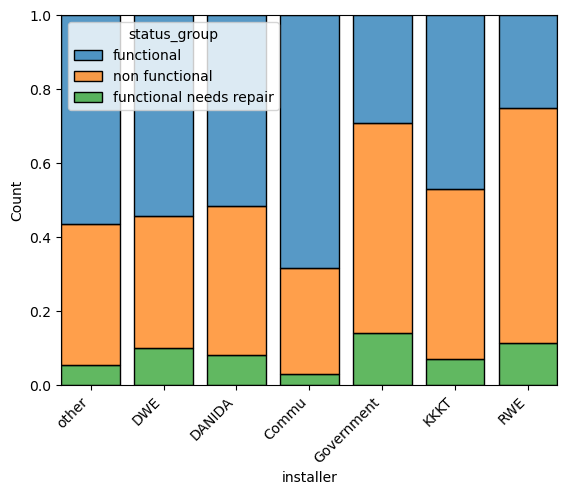

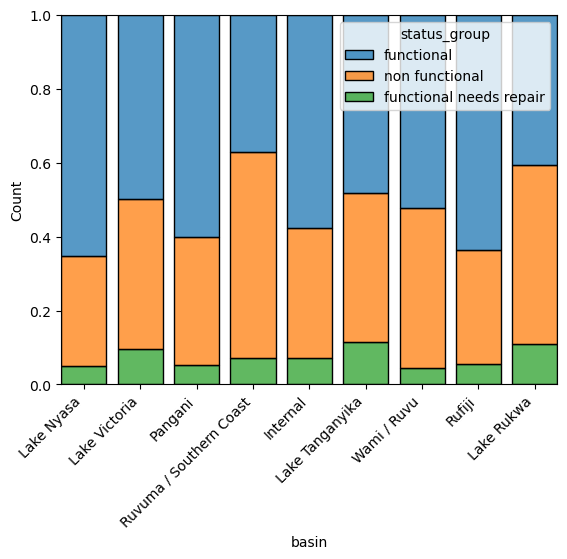

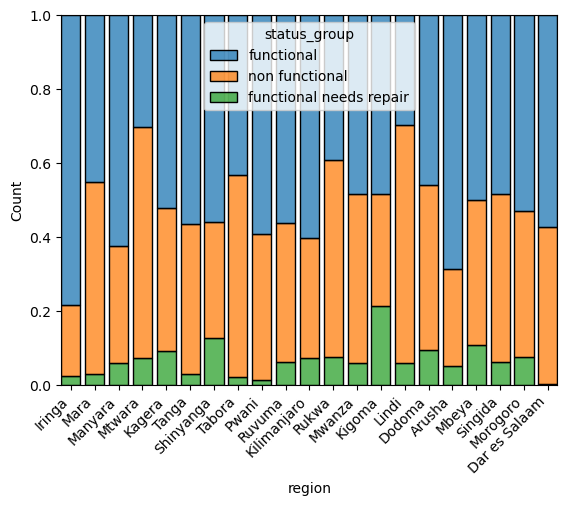

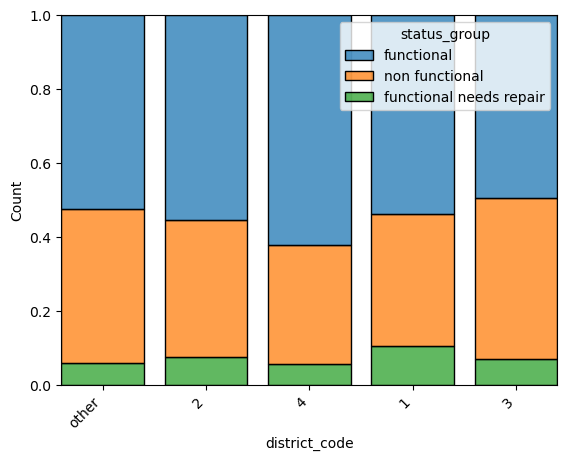

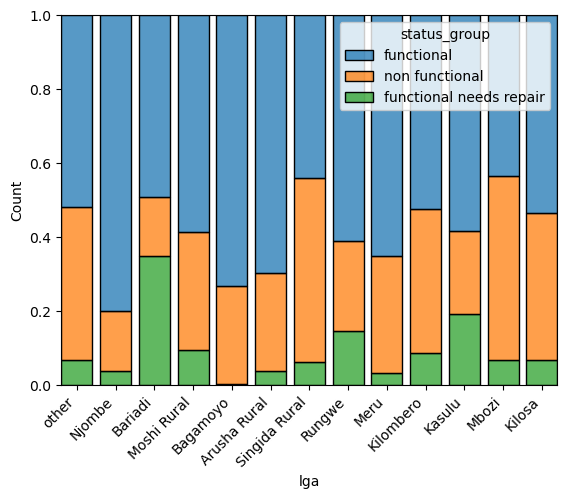

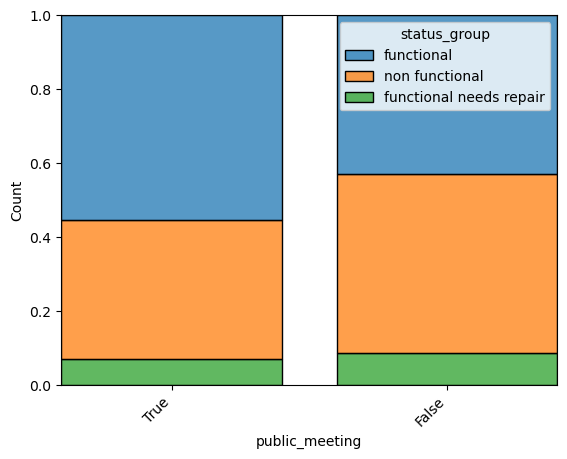

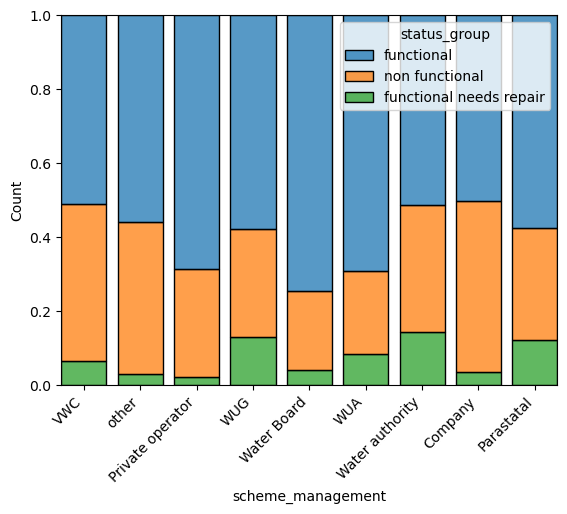

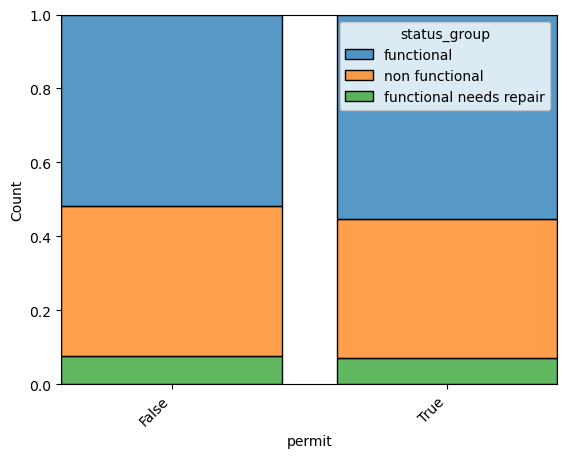

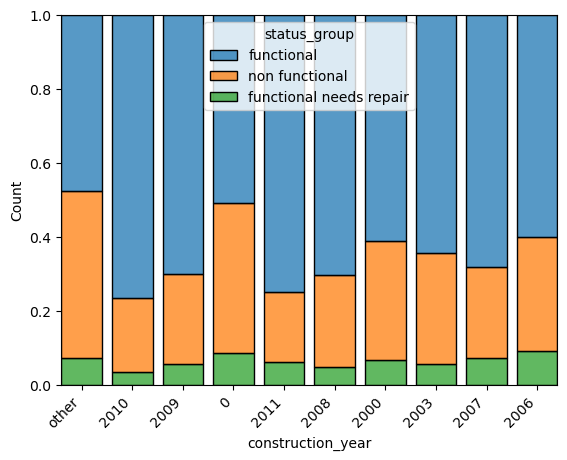

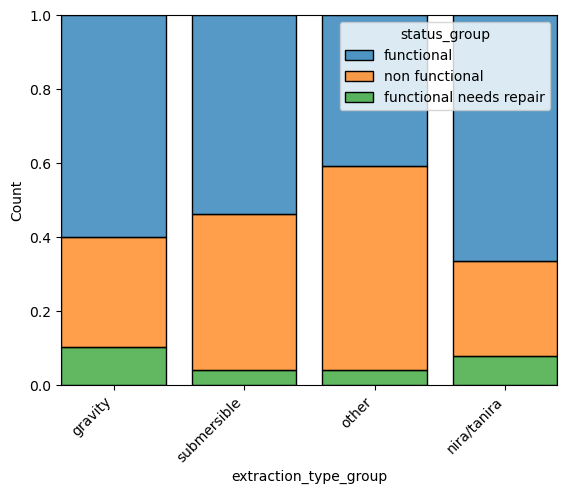

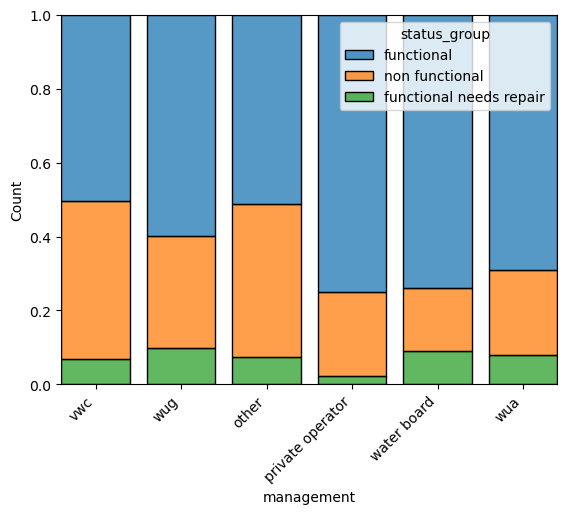

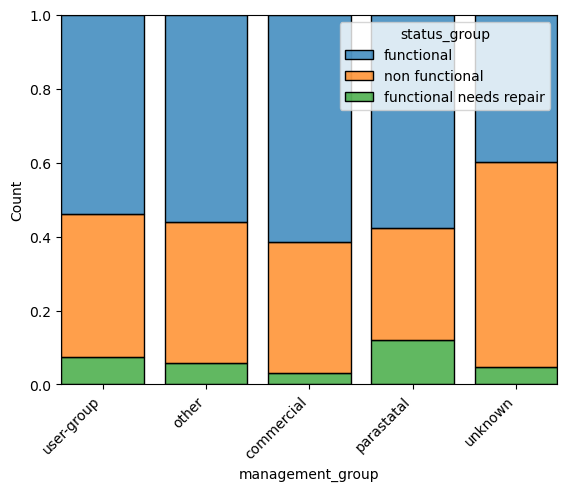

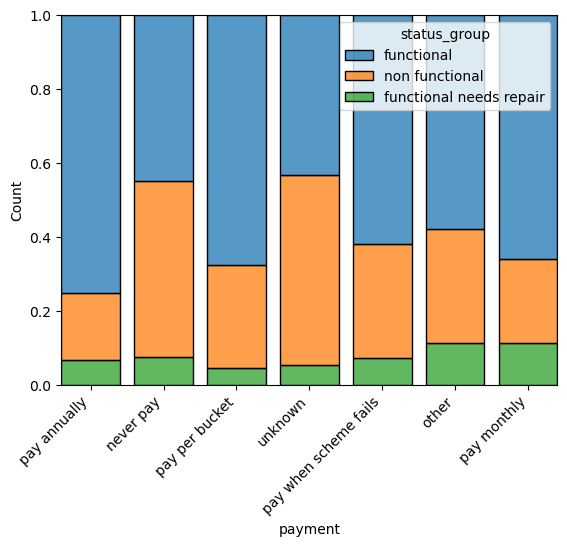

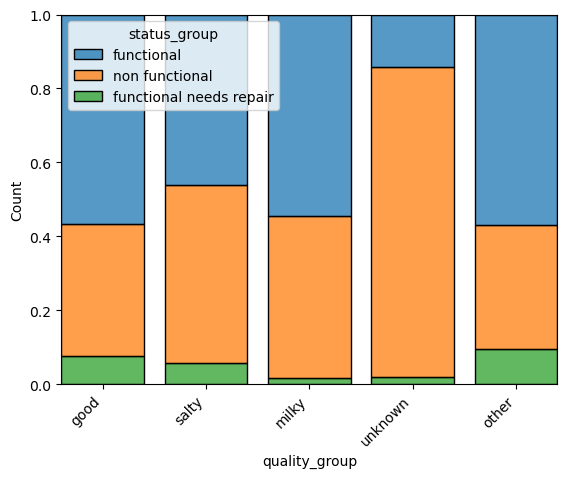

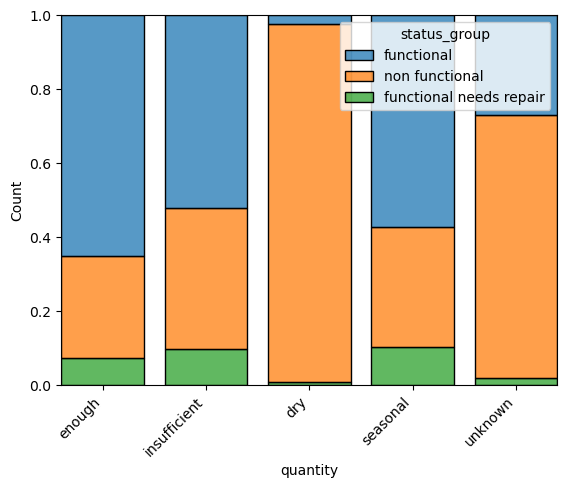

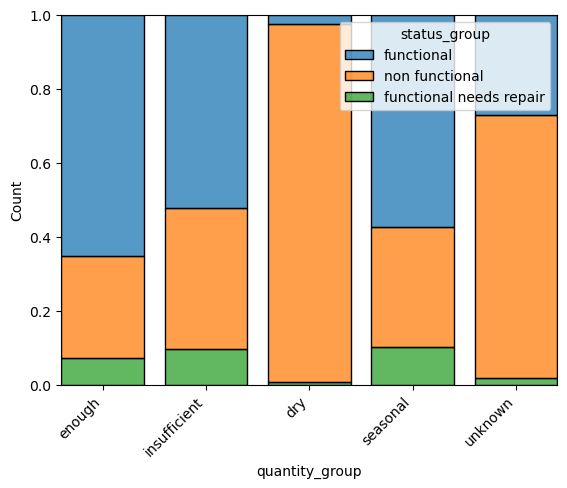

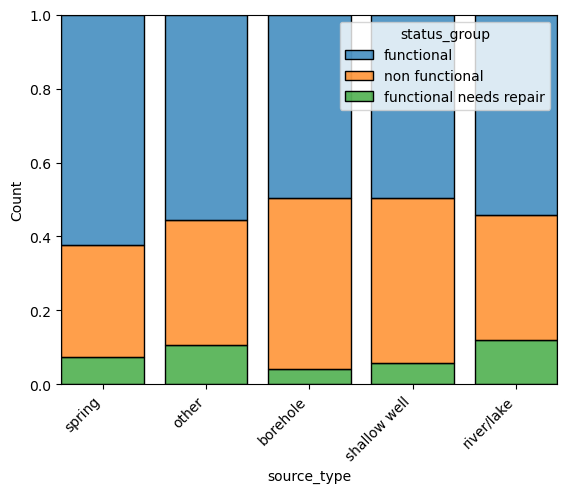

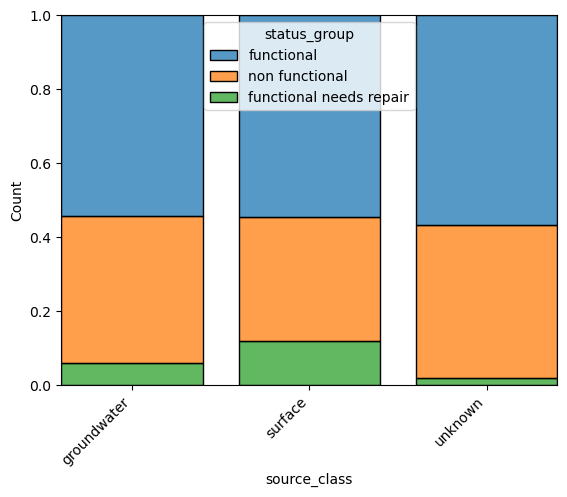

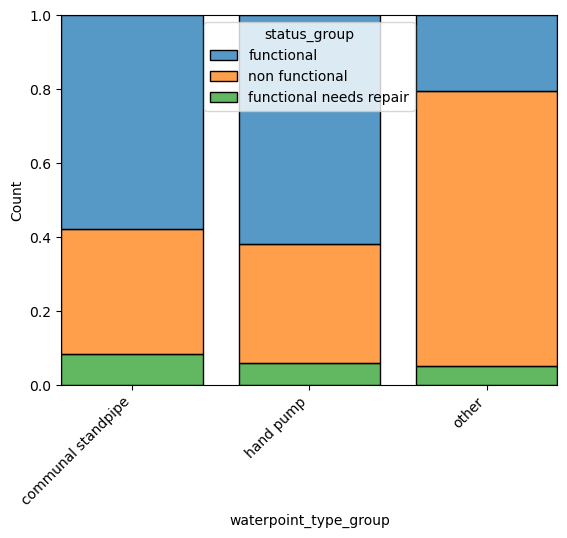

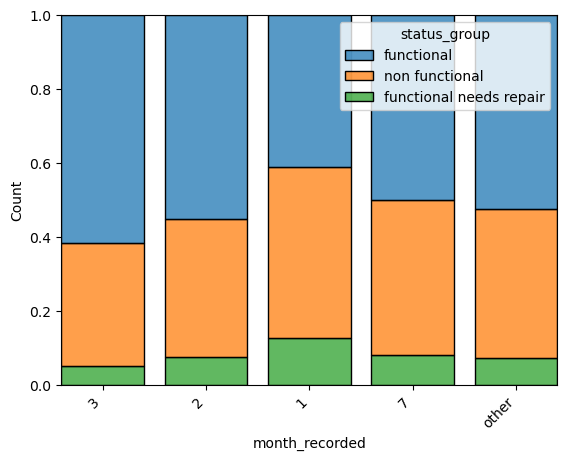

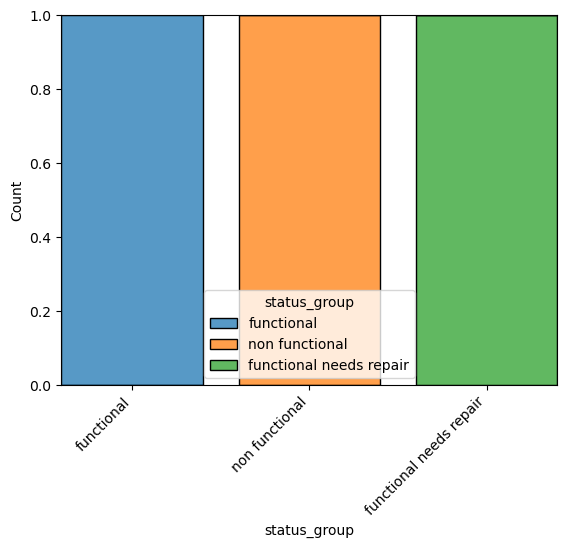

In [98]:
#Grafico de barras
for var in cat_var_.columns:
    sns.histplot(data=total_imputaciones, x=var, hue="status_group", multiple="fill", shrink=.8)
    plt.xticks(rotation=45, ha='right')
    plt.show()

Lo que más nos llama la atención es lo siguiente:

    - Si la instalación es por parte del gobierno o por RWE es más probable que las bombas de agua NO vayan a ser funcionales. En cambio, si son instaladas por "Commu", es más probable que sí funcionen.
    
    - Las regiones Iringa y Arusha son las que cuentan con más bombas de agua funcionales, igual que Njombe. En Dar es Salaam prácticamente ninguna suele necesitar reparación. Lindi y Mtwana son las regiones que cuentan con menos bombas de agua funcionales.
    
    - Las instaladas en 2010 y 2009 son las que mejor están funcionando.
    
    - Cuando están gestionadas por un operador privado suelen funcionar mejor.
    
    - La mayoría de bombas no funcionales no tienen registrada su calidad del agua. Pasa igual con la cantidad de agua no resgistrada.

Vamos a hacer una matriz de correlación con las variables numéricas para ver si nos puede dar más información sobre la importancia de estas variables:

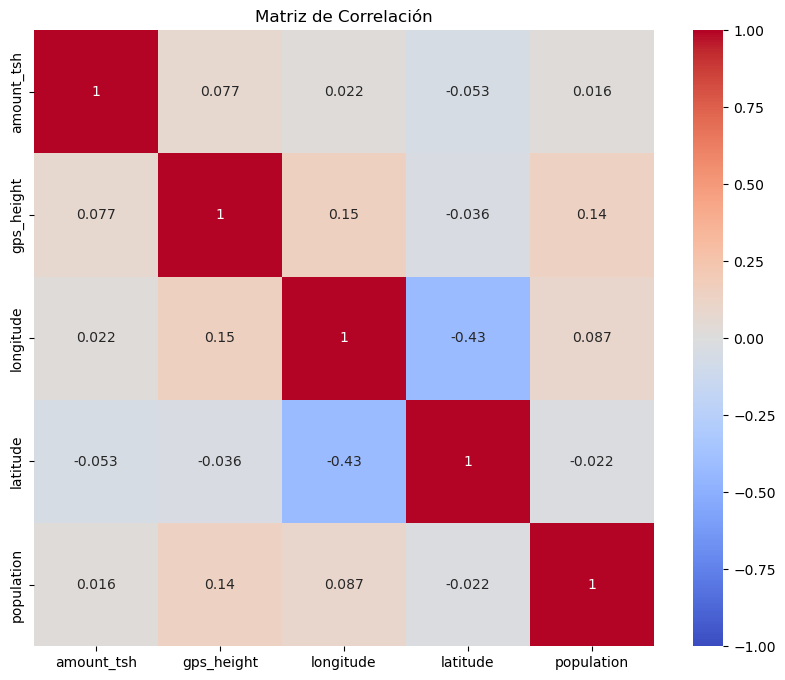

In [99]:
corr_matrix = num_var_.corr(method='pearson')

# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

A primera vista no existe una gran correlación entre las variables numéricas, aunque tendremos en cuenta el 0.43% entre latitud y longitud.

## Ajuste y entrenamiento del modelo

In [100]:
# Separamos las etiquetas del conjunto de entrenamiento
y_train = total_imputaciones['status_group']
X_train = total_imputaciones.drop(['status_group'], axis=1)

In [101]:
# Dummies
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(total_imputaciones_test, drop_first=True)

# Nos aseguramos de que ambas tienen las mismas dimensiones
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [102]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=123)

# Comprobamos las dimensiones
print('Training dataset shape:', X_train_split.shape, y_train_split.shape)
print('Validation dataset shape:', X_test_split.shape, y_test_split.shape)

Training dataset shape: (47520, 116) (47520,)
Validation dataset shape: (11880, 116) (11880,)


**Entrenamiento del modelo**

In [103]:
# Creamos el modelo y lo entrenamos
modelo = RandomForestClassifier(n_estimators=100, random_state=123)
modelo.fit(X_train_split, y_train_split)

RandomForestClassifier(random_state=123)

In [104]:
# Evaluamos el modelo
y_test_pred = modelo.predict(X_test_split)
print(classification_report(y_test_split, y_test_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      6357
functional needs repair       0.49      0.35      0.41       845
         non functional       0.83      0.79      0.81      4678

               accuracy                           0.80     11880
              macro avg       0.71      0.67      0.69     11880
           weighted avg       0.79      0.80      0.80     11880



**Evaluación en el conjunto de prueba**

In [105]:
# Realizamos las predicciones usando el modelo entrenado
y_test_pred = modelo.predict(X_test_encoded)

# Guardamos las predicciones en un archivo CSV
submission_ok = pd.DataFrame({'id': total_imputaciones_test.index, 'status_group': y_test_pred})
submission_ok.to_csv('submission_ok.csv', index=False)

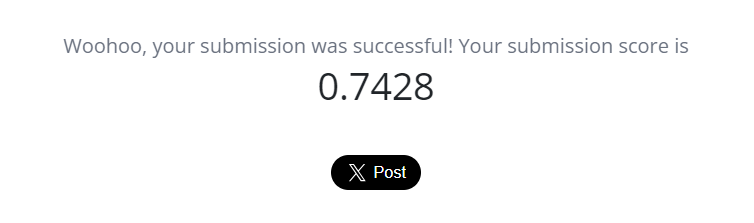

Intentaremos seguir mejorando el modelo con los siguientes pasos. Primero, para manejar el desbalanceo de clases vamos a usar la técnica de **SMOTE**, y luego probaremos a añadir **optimizadores**:

**SMOTE**

In [106]:
# Aplicamos SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_split, y_train_split)

**GridSearchCV**

In [107]:
# Definimos el nuevo modelo
modelo_grid = RandomForestClassifier(n_estimators=100, random_state=123)

# Definir el rango de parámetros para optimizar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [157]:
# Aplicamos GridSearchCV para encontrar los mejores parámetros
grid_search = GridSearchCV(estimator=modelo_grid, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtenemos el mejor modelo
best_rf_model = grid_search.best_estimator_
print(f"Mejores Hiperparámetros: {grid_search.best_params_}")

Mejores Hiperparámetros: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [158]:
# Evaluamos el modelo en el conjunto de prueba (no balanceado)
y_valid_pred = best_rf_model.predict(X_test_split)
print(classification_report(y_test_split, y_valid_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.83      0.83      6357
functional needs repair       0.41      0.46      0.43       845
         non functional       0.83      0.79      0.81      4678

               accuracy                           0.79     11880
              macro avg       0.69      0.69      0.69     11880
           weighted avg       0.79      0.79      0.79     11880



Evaluamos el rendimiento del modelo en un conjunto de prueba que no haya sido alterado por SMOTE para obtener una estimación precisa del rendimiento del modelo.

In [159]:
# Realizamos las predicciones usando el modelo entrenado en el conjunto de prueba original
y_test_pred_final = best_rf_model.predict(X_test_encoded)

# Guardamos las predicciones en un archivo CSV
submission_final = pd.DataFrame({'id': total_imputaciones_test.index, 'status_group': y_test_pred_final})
submission_final.to_csv('submission_final.csv', index=False)

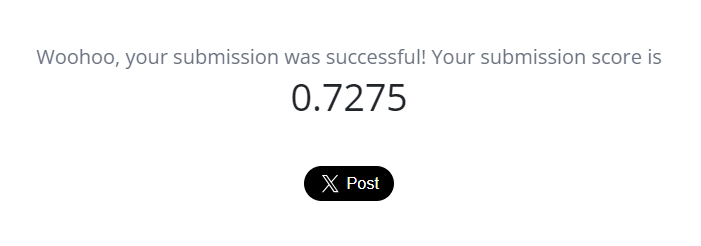

Parece ser que SMOTE no está ayudando a mejorar el rendimiento del modelo, ya que si probamos a **usar optimizadores sin realizar el balanceo conseguimos un mejor score**. Esto se puede deber al sobreajuste del modelo al conjunto balanceado. 

Los hiperparámetros sin usar SMOTE son los siguientes:

   *Mejores hiperparámetros: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}*

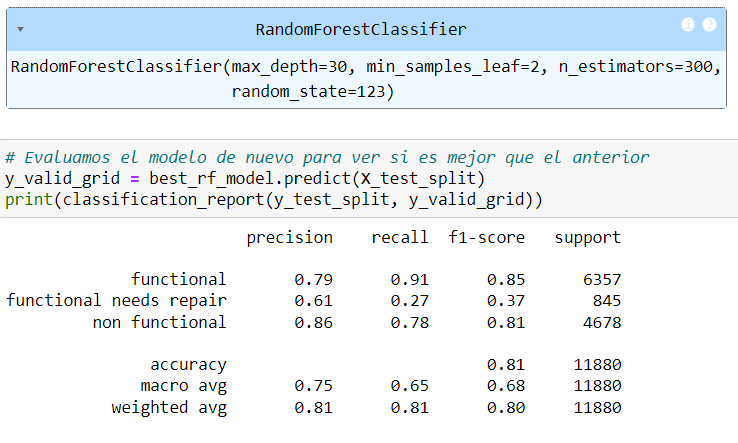

Y nos daban el siguiente score:

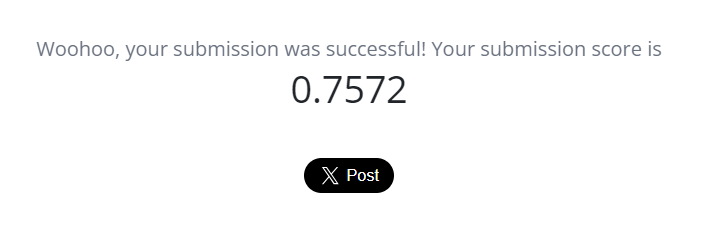

También probamos a aplicar **PCA** a nuestro "best_rf_model" para reducir un poco más la dimensionalidad de los datos. Usamos los hiperparámetros con los que habíamos obtenido el mejor score (0.7572), ya que lo probamos sobre los datos sin balancear (sin SMOTE).  Sin embargo, esto tampoco ayudó. **El score obtenido no llegaba ni siquiera al 0.70**. Es probable que la simplificación introducida por PCA haya acabado eliminando características importantes que son necesarias para que el modelo haga predicciones precisas.

Por lo tanto, pasamos a probar con otros modelos diferentes a RandomForest.

Probamos primero con **Gradient Boosting** al ser una opción más simple y directa, pero decidimos descartarla y seguir probando con **XGBoost**, ya que incluye una serie de mejoras técnicas con respecto a Gradient Boosting (y comprobamos que nos dio un score mayor que Gradient Boosting).

**XGBoost**

Debido a que este clasificador (como muchos otros) espera que las etiquetas 'y' sean valores numéricos, pero en nuestros caso se trata de cadenas de texto ('functional', 'functional needs repair' y 'non functional'), debemos **convertir las etiquetas categóricas a valores numéricos antes de entrenar el modelo**.

Primero probamos el modelo solo y luego aplicando optimizadores (en el siguiente código mostrarémos solo el modelo con optimizadores). En este caso, probamos con **RandomizedSearchCV** en lugar de con GridSearchCV, ya que en el modelo anterior al probar exhaustivamente todas las combinaciones posibles con esta ténica tardaba demasiado. Esta nueva técnica de búsqueda de hiperparámetros explora un espacio de hiperparámetros de manera aleatoria, probando una cantidad específica de combinaciones (en nuestro caso 50).

In [110]:
# Usamos LabelEncoder para convertir las etiquetas
le = LabelEncoder()

# Convertimos las etiquetas de entrenamiento y prueba
y_train_split_encoded = le.fit_transform(y_train_split)
y_test_split_encoded = le.transform(y_test_split)

In [156]:
# Definimos el grid de hiperparámetros usando distribuciones
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# Creamos el modelo 
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Configuramos RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions,
                                       n_iter=50, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2, random_state=123)
                                        # Usamos 'f1_weighted' al ser una tércnica más robusta en escenarios con clases desbalanceadas

# Entrenamos el modelo
random_search_xgb.fit(X_train_split, y_train_split_encoded)

# Obtenemos el mejor modelo
best_xgb_model_rsh = random_search_xgb.best_estimator_
print(f"Mejores Hiperparámetros: {random_search_xgb.best_params_}")

Mejores Hiperparámetros: {'colsample_bytree': 0.9950564827610666, 'learning_rate': 0.033809737113404716, 'max_depth': 19, 'n_estimators': 441, 'subsample': 0.7613628578639282}


In [151]:
# Evaluamos en el conjunto de prueba
y_test_pred_rsh = best_xgb_model_rsh.predict(X_test_split)

# Transformamos las etiquetas predichas de nuevo a su forma original
y_test_pred_rsh_original = le.inverse_transform(y_test_pred_rsh)

# Transformamos también las etiquetas de prueba originales (y_test_split_encoded)
y_test_split_encoded_original = le.inverse_transform(y_test_split_encoded)

# Imprimimos la evaluación
print(classification_report(y_test_split_encoded_original, y_test_pred_rsh_original))

                         precision    recall  f1-score   support

             functional       0.80      0.89      0.84      6357
functional needs repair       0.56      0.33      0.42       845
         non functional       0.85      0.79      0.82      4678

               accuracy                           0.81     11880
              macro avg       0.74      0.67      0.69     11880
           weighted avg       0.80      0.81      0.80     11880



In [152]:
# Predicciones finales y guardamos los resultados
y_test_pred_rsh_final = best_xgb_model_rsh.predict(X_test_encoded)

submission_rsh_ = pd.DataFrame({'id': total_imputaciones_test.index, 'status_group': y_test_pred_rsh_final})
submission_rsh_.to_csv('submission_rsh_.csv', index=False)

Los hiperparámetros obtenidos nos ayudaron a subir un poco la preción ('accuracy') del modelo. Sin embargo, **ninguno de los modelos XGBoost (el simple y el optimizado) llegaron a superar el score de 0.7572**.

El score de XGBoost puede ser más bajo porque, aunque tenemos una mejor precisión en clases mayoritarias (functional, non functional), puede que no esté manejando bien la clase minoritaria (functional needs repair). 

Aplicamos SMOTE para manejar el desbalanceo de clases, pero igual que en el resto de casos, **nos bajaba el score** (no llegaba ni a 0.70).

# CONCLUSIÓN

Después de haber probado diferentes técnicas de preprocesado, selección de datos, optimizadores, etc. Hemos visto cómo el mejor score lo hemos conseguido con la primera prueba (un 0.80), por lo que **nos quedaríamos con el primer modelo**.

Sin embargo, antes dar este modelo como definitivo, quisimos probarlo también con optimizadores:

Primero probamos con **GridSearchCV y nos arrojó un score de 0.8103**. Un score bastante bueno, pero luego probamos con **RandomizedSearchCV** y mejoró este resultado:

**RandomizedSearchCV**

In [147]:
#Copiamos de nuevo todos los pasos de "Primer Modelo" para que no haya ningún dato alterado
df_train_prueba = pd.read_csv("x_train.csv", index_col=0)
y_train_prueba = pd.read_csv("y_train.csv", index_col=0)
df_test_prueba = pd.read_csv("x_test.csv", index_col=0)

# Probamos eliminando columnas innecesarias (según nuestro criterio) para el entrenamiento y validación del modelo
columns_to_drop = [
    'date_recorded','funder', 'installer','wpt_name','num_private','subvillage','region','lga','ward',
    'recorded_by','scheme_name','extraction_type_group','extraction_type_class',
    'management_group','payment_type','quality_group','source_type',
    'source_class','waterpoint_type_group']

df_train_prueba = df_train_prueba.drop(columns=columns_to_drop)
df_test_prueba = df_test_prueba.drop(columns=columns_to_drop)

# Imputamos los valores nulos de forma rápida: la media para valores numéricos y moda para los categóricos
cat_var = df_train_prueba.select_dtypes(include=['object']).columns
num_var = df_train_prueba.select_dtypes(include=[np.number]).columns

# Imputación de variables categóricas con la moda
imputer_cat = SimpleImputer(strategy='most_frequent')
df_train_prueba[cat_var] = imputer_cat.fit_transform(df_train_prueba[cat_var])
df_test_prueba[cat_var] = imputer_cat.transform(df_test_prueba[cat_var])

# Imputación de variables numéricas con la media
imputer_num = SimpleImputer(strategy='mean')
df_train_prueba[num_var] = imputer_num.fit_transform(df_train_prueba[num_var])
df_test_prueba[num_var] = imputer_num.transform(df_test_prueba[num_var])

# Convertimos las variables categóricas en dummies
df_train_dummies = pd.get_dummies(df_train_prueba, drop_first=True)
df_test_dummies = pd.get_dummies(df_test_prueba, drop_first=True)
                        
# Nos aseguramos de que ambas tablas tienen las mismas columnas después de las dummies
df_train_dummies, df_test_dummies = df_train_dummies.align(df_test_dummies, join='left', axis=1, fill_value=0)

# Separamos características y etiquetas
X_train = df_train_dummies
y_train_ = y_train_prueba

# Escalamos las variables numéricas
scaler = MinMaxScaler()
X_train[num_var] = scaler.fit_transform(X_train[num_var])
df_test_dummies[num_var] = scaler.transform(df_test_dummies[num_var])

# Dividimos el conjunto de entrenamiento para una evaluación rápida
X_train, X_test, y_train_, y_test = train_test_split(X_train, y_train_, test_size=0.2, stratify=y_train_, random_state=123)

# Comprobamos dimensiones
print('Training dataset shape:', X_train.shape, y_train_.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)

Tuvimos que convertir las etiquetas categóricas a valores numéricos igual que con XGBoost.

In [138]:
# Usamos LabelEncoder para convertir las etiquetas
le = LabelEncoder()

# Convertimos las etiquetas de entrenamiento y prueba
y_train_encoded = le.fit_transform(y_train_)
y_test_encoded = le.transform(y_test)

In [140]:
# Definimos el rango de parámetros para optimizar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configuramos RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=modelo_prueba_grid, param_distributions=param_grid,
                                       n_iter=50, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2, random_state=123)

# Entrenamos el modelo
random_search_xgb.fit(X_train, y_train_encoded)

# Obtenemos el mejor modelo
best_rf_model_prueba = random_search_xgb.best_estimator_
print(f"Mejores Hiperparámetros: {random_search_xgb.best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores Hiperparámetros: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30}


In [143]:
# Evaluamos el modelo en el conjunto de prueba
y_pred_prueba = best_rf_model_prueba.predict(X_test)
print(classification_report(y_test_encoded, y_pred_prueba))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      6452
           1       0.57      0.33      0.41       863
           2       0.84      0.77      0.80      4565

    accuracy                           0.80     11880
   macro avg       0.73      0.66      0.69     11880
weighted avg       0.80      0.80      0.80     11880



In [145]:
# Realizamos las predicciones
y_test_pred_prueba = best_rf_model_prueba.predict(df_test_dummies)

# Decodificamos las predicciones para que tengan el formato correcto
y_test_pred_prueba_decoded = le.inverse_transform(y_test_pred_prueba)

# Guardamos las predicciones en un archivo CSV
submission_prueba_rs = pd.DataFrame({'id': df_test_prueba.index, 'status_group': y_test_pred_prueba_decoded})
submission_prueba_rs.to_csv('submission_prueba_rs.csv', index=False)

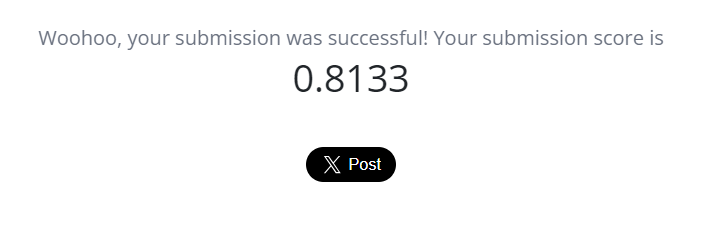

Hemos conseguido un modelo con un score del 0.8133. **Nos quedaríamos finalmente con el primer modelo de prueba añadiendo los hiperparámetros obtenidos mediante RandomizedSearchCV**.